In [4]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTENC
from scipy import stats
import pylab

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_classif
from scipy.stats import boxcox, chi2_contingency
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, CategoricalNB

import pickle
import warnings
warnings.filterwarnings('ignore')

In [5]:
%matplotlib inline
# %matplotlib widget

In [6]:
# For styling texts and graphs/charts
class Color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'
    
    

# sns.set_theme()
# plt.style.available

# plt.style.use('dark_background')
# plt.style.use('classic')
# plt.style.use(plt.style.available[-1])
plt.style.use('seaborn-whitegrid')

In [7]:
# loading csv data
DF = pd.read_csv('E:\Datasets\Aus Weather\weatherAUS.csv')
pd.set_option('display.max_columns', DF.shape[-1] + 10)
pd.set_option('display.max_rows', 50)
DF.drop_duplicates(inplace = True)
DF.shape

(145460, 23)

In [8]:
# setting target name
target_name = DF.columns[-1]
target_name

'RainTomorrow'

In [9]:
# Dropping rows which have null values
def drop_nan_target(data, target, reset_index = True):
    out = data.loc[~data[target].isnull(), :]
    if reset_index:
        out = out.reset_index().drop('index', axis = 1)
    print(data[target].isnull().sum(), 'null target rows removed!')
    return out
df = drop_nan_target(DF, target_name)
df.shape

3267 null target rows removed!


(142193, 23)

In [10]:
# changing raintoday & raintomorrow values to binary from string
df['RainToday'] = df['RainToday'].map({'No': 0, 'Yes': 1})
df['RainTomorrow'] = df['RainTomorrow'].map({'No': 0, 'Yes': 1})

In [11]:
# Splitting Date into dates, weeks, months, years

date_time = df.Date.str.split('-', expand = True)
date_time.columns = ['year', 'month', 'date']
date_time['week_year'] = pd.to_datetime(df.Date).dt.isocalendar().week
date_time['week_day'] = pd.to_datetime(df.Date).dt.weekday+1
date_time = date_time.astype('int32')
date_time['week_month'] = date_time.values[:, [2, -1]].tolist()


def set_week_month(x):
    date, weekday = x
    def check_week(x, y):
        for k in range(1, 8):
            if x == k:
                if y in range(k, 8):
                    return 0
                return 1
            
    if ((date > 31) | (date <= 0)) | ((weekday > 7) | (weekday <= 0)):
        raise Exception('Dates must be between 1 & 31')
        
    for j, i in enumerate(range(0, 32, 7)):

        if (date > i) & (date <= i+7):
            date -= j*7
            return (j+1) + check_week(date, weekday)

date_time['week_month'] = date_time['week_month'].apply(set_week_month)

weekdays = {
    1: 'Monday',
    2: 'Tuesday',
    3: 'Wednesday',
    4: 'Thursday',
    5: 'Friday',
    6: 'Saturday',
    7: 'Sunday'
}

def convert_days(x):
    return weekdays[x]

date_time['week_day'] = date_time['week_day'].apply(convert_days)

df = pd.merge(date_time, df, left_index = True, right_index = True)
df.drop('Date', axis = 1, inplace = True)
df.rename({'year': 'Year', 'month': 'Month', 'date': 'Date', 
           'week_year': 'WeekYear', 'week_day': 'WeekDay', 'week_month': 'WeekMonth'}, axis = 1, inplace = True)

df

,Year,Month,Date,WeekYear,WeekDay,WeekMonth,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008,12,1,49,Monday,1,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,0.0,0
1,2008,12,2,49,Tuesday,1,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,0.0,0
2,2008,12,3,49,Wednesday,1,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,0.0,0
3,2008,12,4,49,Thursday,1,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,0.0,0
4,2008,12,5,49,Friday,1,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142188,2017,6,20,25,Tuesday,4,Uluru,3.5,21.8,0.0,NaN,NaN,E,31.0,ESE,E,15.0,13.0,59.0,27.0,1024.7,1021.2,NaN,NaN,9.4,20.9,0.0,0
142189,2017,6,21,25,Wednesday,4,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,ENE,13.0,11.0,51.0,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,0.0,0
142190,2017,6,22,25,Thursday,4,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,N,13.0,9.0,56.0,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,0.0,0
142191,2017,6,23,25,Friday,4,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,WNW,9.0,9.0,53.0,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,0.0,0


In [12]:
# keeping some non-null data which will only be used for testing and not be used anywhere
# This is data which could come from outside real world

while True:
    r = 0
    TestXY = df.dropna().sample(int(df.shape[0]*0.05))
    for loc in TestXY.Location.unique():
        if loc not in df.Location.unique():
            r += 1
    
    if r == 0:
        break
    
TestX, TestY = TestXY.loc[:, :target_name], TestXY.loc[:, target_name]

assert TestXY.isnull().sum().sum() == 0

df = df.iloc[list(set(df.index.values) - set(TestXY.index.values)), :]
df = df.reset_index().drop('index', axis = 1)
df.shape, TestXY.shape

((135084, 28), (7109, 28))

In [13]:
# keeping some data which will used for testing (validation set)
# and cleaning of this data will be done sepeately

while True:
    r = 0
    Valdf = df.sample(int(df.shape[0]*0.15))
    for loc in Valdf.Location.unique():
        if loc not in df.Location.unique():
            r += 1
        
    if r == 0:
        break

df = df.iloc[list(set(df.index.values) - set(Valdf.index.values)), :]
df = df.reset_index().drop('index', axis = 1)
df.shape, Valdf.shape

((114822, 28), (20262, 28))

In [14]:
df.shape

(114822, 28)

### Start working with data

In [15]:
num_cols = []
cat_cols = list(df.columns[:6])
thresh = 15
for col in df.columns[6:-1]:
    if df[col].dtype.name not in ['int32', 'int64', 'float32', 'float64']:
        cat_cols.append(col)
        
    else:
        if df[col].nunique() <= thresh:
            cat_cols.append(col)
        else:
            num_cols.append(col)
        
print(f'Numerical Columns: \n{num_cols}\n')
print(f'Categorical Columns: \n{cat_cols}')

Numerical Columns: 
['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm']

Categorical Columns: 
['Year', 'Month', 'Date', 'WeekYear', 'WeekDay', 'WeekMonth', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'Cloud9am', 'Cloud3pm', 'RainToday']


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114822 entries, 0 to 114821
Data columns (total 28 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Year           114822 non-null  int32  
 1   Month          114822 non-null  int32  
 2   Date           114822 non-null  int32  
 3   WeekYear       114822 non-null  int32  
 4   WeekDay        114822 non-null  object 
 5   WeekMonth      114822 non-null  int64  
 6   Location       114822 non-null  object 
 7   MinTemp        114264 non-null  float64
 8   MaxTemp        114537 non-null  float64
 9   Rainfall       113629 non-null  float64
 10  Evaporation    63161 non-null   float64
 11  Sunshine       57169 non-null   float64
 12  WindGustDir    106930 non-null  object 
 13  WindGustSpeed  106976 non-null  float64
 14  WindDir9am     106292 non-null  object 
 15  WindDir3pm     111623 non-null  object 
 16  WindSpeed9am   113649 non-null  float64
 17  WindSpeed3pm   112581 non-nul

In [17]:
df.describe()

,Year,Month,Date,WeekYear,WeekMonth,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
count,114822.000000,114822.000000,114822.000000,114822.000000,114822.000000,114264.000000,114537.000000,113629.000000,63161.000000,57169.000000,106976.000000,113649.000000,112581.000000,113296.000000,111750.000000,102927.000000,102965.000000,69227.000000,66264.000000,114033.000000,112505.00000,113629.000000,114822.000000
mean,2012.789143,6.399488,15.706154,26.102942,3.095034,12.125611,23.179607,2.369574,5.478305,7.621164,39.941370,13.920202,18.593404,68.999682,51.570389,1017.664043,1015.269402,4.449608,4.512586,16.930186,21.64214,0.223816,0.224356
std,2.543876,3.424915,8.795045,14.972811,1.317553,6.402317,7.120377,8.593883,4.247795,3.781592,13.612667,8.924352,8.817893,19.076167,20.822647,7.123416,7.052932,2.895045,2.725341,6.490826,6.93794,0.416802,0.417159
min,2007.000000,1.000000,1.000000,1.000000,1.000000,-8.500000,-4.100000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.500000,977.100000,0.000000,0.000000,-7.000000,-5.10000,0.000000,0.000000
25%,2011.000000,3.000000,8.000000,13.000000,2.000000,7.500000,17.900000,0.000000,2.600000,4.900000,31.000000,7.000000,13.000000,57.000000,37.000000,1013.000000,1010.500000,1.000000,2.000000,12.200000,16.60000,0.000000,0.000000
50%,2013.000000,6.000000,16.000000,26.000000,3.000000,11.900000,22.600000,0.000000,4.800000,8.400000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.700000,1015.300000,5.000000,5.000000,16.700000,21.10000,0.000000,0.000000
75%,2015.000000,9.000000,23.000000,39.000000,4.000000,16.800000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.400000,1020.000000,7.000000,7.000000,21.500000,26.40000,0.000000,0.000000
max,2017.000000,12.000000,31.000000,53.000000,6.000000,31.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.000000,1039.600000,9.000000,9.000000,40.200000,46.70000,1.000000,1.000000


In [18]:
df.isnull().sum()

Year                 0
Month                0
Date                 0
WeekYear             0
WeekDay              0
WeekMonth            0
Location             0
MinTemp            558
MaxTemp            285
Rainfall          1193
Evaporation      51661
Sunshine         57653
WindGustDir       7892
WindGustSpeed     7846
WindDir9am        8530
WindDir3pm        3199
WindSpeed9am      1173
WindSpeed3pm      2241
Humidity9am       1526
Humidity3pm       3072
Pressure9am      11895
Pressure3pm      11857
Cloud9am         45595
Cloud3pm         48558
Temp9am            789
Temp3pm           2317
RainToday         1193
RainTomorrow         0
dtype: int64

In [19]:
for col in df.columns:
    print(f'{Color.UNDERLINE + Color.BOLD + col.upper() + Color.END + Color.END}:')
    print(f'{Color.BOLD}Null Values:{Color.END} {df[col].isnull().sum()}')
    print(f'{Color.BOLD}Unique Values:{Color.END} {df[col].nunique()}')
    print(f'{df[col].unique()}')
    print(pd.DataFrame({'Counts': df[col].value_counts(), 'Percent': df[col].value_counts(normalize = True)}))
    print('*' * 100)
    print('\n\n')

YEAR:
Null Values: 0
Unique Values: 11
[2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2007]
      Counts   Percent
2016   14419  0.125577
2014   14125  0.123016
2015   13892  0.120987
2009   13217  0.115109
2010   13115  0.114220
2013   12978  0.113027
2012   12111  0.105476
2011   12101  0.105389
2017    7058  0.061469
2008    1753  0.015267
2007      53  0.000462
****************************************************************************************************



MONTH:
Null Values: 0
Unique Values: 12
[12  1  2  3  4  5  6  7  8  9 10 11]
    Counts   Percent
5    10618  0.092474
3    10493  0.091385
1    10421  0.090758
6    10049  0.087518
10    9528  0.082981
7     9519  0.082902
8     9512  0.082841
11    9256  0.080612
4     9127  0.079488
9     9061  0.078913
12    8716  0.075909
2     8522  0.074219
****************************************************************************************************



DATE:
Null Values: 0
Unique Values: 31
[ 1  2  4  5  6  7  8  9 11 12

Null Values: 3199
Unique Values: 16
['WNW' 'WSW' 'E' 'NW' 'W' 'ESE' 'ENE' 'NNW' 'SSW' 'SW' 'SE' 'SSE' 'NNE'
 'S' 'NE' nan 'N']
     Counts   Percent
SE     8640  0.077403
W      8031  0.071948
S      7696  0.068946
WSW    7550  0.067638
SSE    7399  0.066286
SW     7372  0.066044
WNW    6994  0.062657
N      6990  0.062622
NW     6876  0.061600
E      6716  0.060167
ESE    6659  0.059656
NE     6594  0.059074
SSW    6451  0.057793
NNW    6305  0.056485
ENE    6106  0.054702
NNE    5244  0.046980
****************************************************************************************************



WINDSPEED9AM:
Null Values: 1173
Unique Values: 43
[ 20.   4.  11.   7.  19.   6.  17.  15.  28.  24.  nan   9.   0.  26.
  30.   2.  13.  22.  35.  37.  31.  33.  48.  39.  44.  46.  43.  56.
  41.  83.  74.  52.  65.  50. 130.  54.  61.  57.  59.  87.  63.  69.
  72.  67.]
       Counts   Percent
9.0     10753  0.094616
13.0    10291  0.090551
11.0     9278  0.081637
7.0      8561  0.075328


### Heatmap

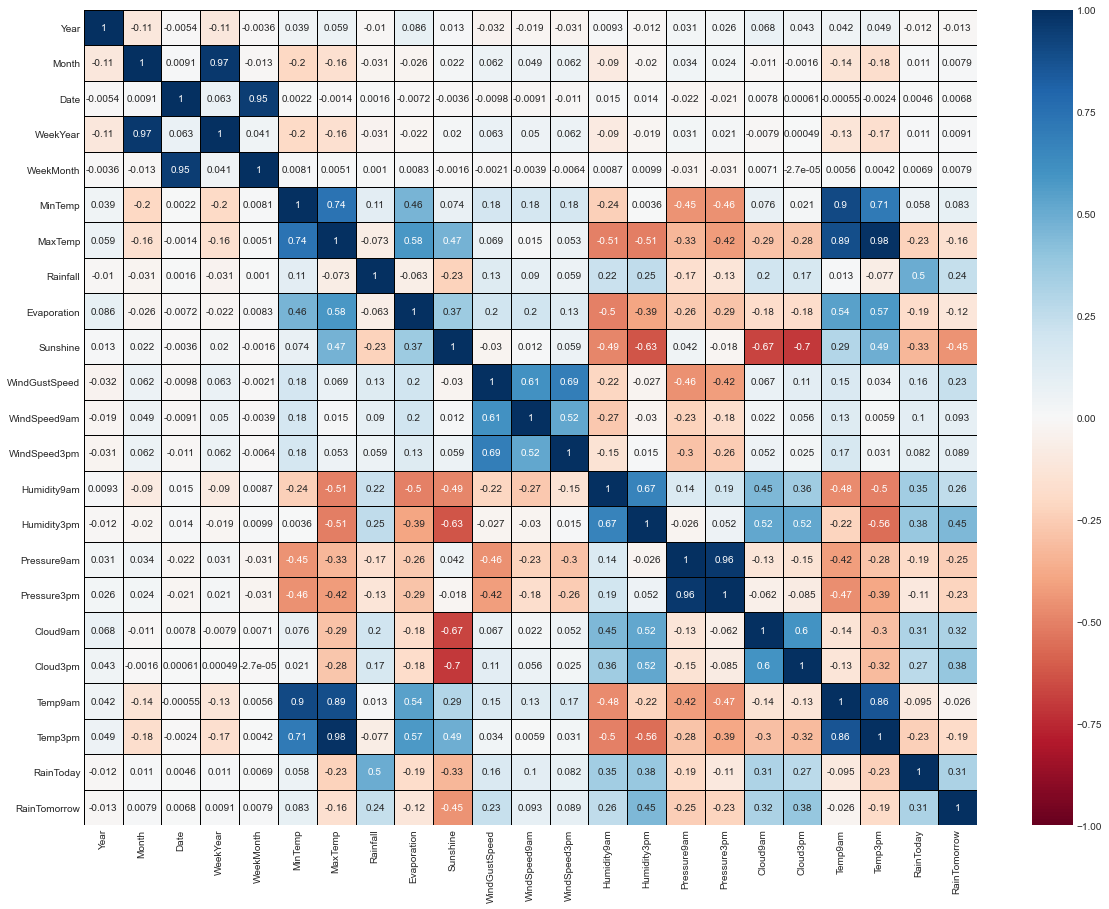

In [20]:
# Heatmap for analysing correlation between numerical columns
plt.figure(figsize = (20, 15))
sns.heatmap(df.corr(), annot = True, cmap = 'RdBu', vmax = 1, vmin = -1, linewidths = 1, linecolor = 'black')
plt.show()

### Handling Nan Values

In [21]:
# Class is created for cleaning data
class CleanData(object):
    def __init__(self, df):
        self.__df = df
        
class NaiveHandle(CleanData):
    def __init__(self, df):
        super().__init__(df)
        self.__df = df
        self.df = self.__df
        
    @property
    def reset_data(self):
        self.df = self.__df
        
    @property
    def cleaned_data(self):
        return self.df
        
    def isnull(self, col = None, check_type = 'any'):
        if col is None:
            null = self.df.isnull()
        else:
            null = self.df[col].isnull()
        
        if check_type is None:
            return null
        if check_type == 'any':
            return null.any()
        elif check_type == 'all':
            return null.all()
        elif check_type == 'sum':
            return null.sum()
        else:
            raise Exception(f'check_type {check_type} not available.')
            
            
    def dropna(self, col = None, axis = 0):
        if col is None:
            self.df = self.df.dropna()
           
        else:
            if self.isnull(col):
                self.df[col] = self.df[col].dropna(axis = axis)
        
    def fill_mean(self, col):
        if self.isnull(col):
            mean = self.df[col].mean()
            self.df[col] = self.df[col].fillna(mean)
        
    def fill_median(self, col):
        if self.isnull(col):
            median = self.df[col].median()
            self.df[col] = self.df[col].fillna(median)
        
    def fill_mode(self, col):
        if self.isnull(col):
            r = pd.DataFrame(np.random.choice(self.df[col].mode().values, df[col].isnull().sum()))
            r.index = self.df.loc[self.df[col].isnull(), col].index
            self.df.loc[self.df[col].isnull(), col] = r[0]
            
    def fill_sample(self, col):
        if self.isnull(col):
            r = self.df[col].dropna().sample(self.df[col].isnull().sum())
            r.index = self.df.loc[self.df[col].isnull(), col].index
            self.df.loc[self.df[col].isnull(), col] = r
    
    def fill_normal(self, col):
        if self.isnull(col):
            mean, std = self.df[col].dropna().mean(), self.df[col].dropna().std()
            
            normal_vals = np.random.normal(loc = mean, scale = std, size = self.df[col].isnull().sum())
            normal_vals.index = self.df.loc[self.df[col].isnull(), col].index
            self.df.loc[self.df[col].isnull(), col] = normal_vals
            
    def fill_uniform(self, col):
        if self.isnull(col):
            low, high = self.df[col].dropna().min(), self.df[col].dropna().max()
            
            uniform_vals = np.random.uniform(low = low, high = high, size = self.df[col].isnull().sum())
            uniform_vals.index = self.df.loc[self.df[col].isnull(), col].index
            self.df.loc[self.df[col].isnull(), col] = uniform_vals
    
    
    
# loop hierarchy (levels)
class HierarchicalHandle(CleanData):
    '''
    HierarchicalHandle(df, base_level_features = {'Location': 'unique', 'Temp9am': 'range_7'},
                       fill_type = {
                                'WindGustDir': 'sample', 
                                'WindGustDir': 'sample'
                                'WindGustDir': 'mode',
                                'MinTemp': 'normal'}, fill_rest='mode')
    '''
    def __init__(self, df, levels = 2, base_level_features = None, leave_cols = [], 
                 num_cat_thresh = 15, num_range = 10, cat_remainder = None, num_remainder = None, 
                 fill_type = 'sample', fill_rest = 'sample', corr_type = 'pearson'):
        super().__init__(df)
        '''
        note: if `num_remainder` will take all the features whose data_type falls in ['int32', 'int64', 'float32', 
        'float64']. If there is any column whose values are integer but falls into categorical feature. 
        Then `num_remainder` should be 'sample' or 'mode'. Otherwise, it will effect those columns. Or, one could also
        set it as None, if they want to handle it by themselves.
        '''
        
        self.__df = df
        self._df = self.__df
        self.df = self._df
        
        self.cat_remainder = cat_remainder
        self.num_remainder = num_remainder
        
        self.levels = levels
        self.num_cat_thresh = num_cat_thresh
        self.num_range = num_range
        
        self.leave_cols = leave_cols
        
        self.base_level_features = {} if base_level_features is None else base_level_features
        self.total_levels = levels + len(self.base_level_features)
        
        assert corr_type in ['pearson', 'kendall', 'spearman']
        self.corr = self.df.corr(method = corr_type)
        
        if isinstance(fill_type, str):
            assert fill_type in ['mode', 'median', 'mean', 'sample', 'normal'] 
        self.__fill_type = fill_type
        
        self.fill_rest = fill_rest
        self.fill_rest_cat = 'sample'
        
        self.level_info = {}
        self.nan_cols = {}
        for col in self.df.columns:
            if self.df[col].isnull().any():
                self.nan_cols[col] = self.df[col].isnull().sum()
                
        self.set_level_info()
        
        
    def get_support_cols(self, col):
        col_corr = np.abs(self.corr[col].drop(col))
        sup_cols = list(col_corr.nlargest(n = self.levels).index)
        #support_types 
        support_cols = {}
        for sc in sup_cols:
            if self.df[sc].dtype.name in ['int32', 'int64', 'float32', 'float64']:
                if self.df[sc].nunique() > self.num_cat_thresh:
                    support_cols[sc] = f'range_{self.num_range}'
                else:
                    support_cols[sc] = 'unique'

            else:
                support_cols[sc] = 'unique'
                
        return support_cols
    
    
    def support_level_setup(self, support_levels, lvl, col, s_type, offset = 0.01):
        support_levels[lvl] = {}
        support_levels[lvl]['col'] = col
        support_levels[lvl]['support_type'] = s_type
        support_levels[lvl]['data_type'] = self.df[col].dtype.name
        support_levels[lvl]['supports'] = {}

        if s_type == 'unique':
            support_levels[lvl]['supports'] = self.df[col].dropna().unique()

        else:
            cal_type = s_type.split('_')
            assert len(cal_type) == 2, 'invalid calc_type'
            assert cal_type[1].isnumeric() == True, 'range is not defined.'
            cal_type[1] = int(cal_type[1])

            assert self.df[col].dtype in [int, float], f'support type {s_type} is not supported for col {col}'
            support_levels[lvl]['supports'] = np.linspace(self.df[col].min(), self.df[col].max(), cal_type[1])
            if offset>0:
                support_levels[lvl]['supports'][-1] += offset
            elif offset<0:
                support_levels[lvl]['supports'][0] += offset
            
        return support_levels
    
    
    def set_supports_and_levels(self, support_cols):
        
        lvl = 0
        support_levels = {}
        
        for b_key, b_val in self.base_level_features.items():
            lvl += 1
            support_levels = self.support_level_setup(support_levels, lvl, b_key, b_val)
            
        for key, val in support_cols.items():
            if key not in self.base_level_features.keys():
                lvl += 1
                support_levels = self.support_level_setup(support_levels, lvl, key, val)
                
        return support_levels
    
    
    def __check_set_fill_type(self, col, f_type):
        if ((self.level_info[col]['data_type'] in ['float32', 'float64', 'int32', 'int64']) & 
            (f_type in ['mean', 'median', 'mode', 'normal', 'sample'])):
                self.level_info[col]['fill_type'] = f_type

        elif self.level_info[col]['data_type'] not in ['float32', 'float64', 'int32', 'int64']:
            if f_type not in ['sample', 'mode']:
                print(f'`{f_type}` fill_type not supported for `{col}`. So, `sample` is assigned.')
                self.level_info[col]['fill_type'] = 'sample'
            else:
                self.level_info[col]['fill_type'] = f_type
                
                
    def add_fill_type(self, fill_type):
        
        for k in self.level_info.keys():
            if isinstance(fill_type, str):
                self.__check_set_fill_type(k, fill_type)
                
            elif isinstance(fill_type, dict):
                if k in list(fill_type.keys()):
                    self.__check_set_fill_type(k, fill_type[k])
                    
                    
    def __set_fill_type(self, col):
                    
        if isinstance(self.__fill_type, str):
            self.__check_set_fill_type(col, self.__fill_type)

        elif isinstance(self.__fill_type, dict):
            if col in list(self.__fill_type.keys()):
                self.__check_set_fill_type(col, self.__fill_type[col])
            
            else:
                self.__check_set_fill_type(col, self.fill_rest)


    def set_level_info(self):
        if hasattr(self, 'level_info'):
            for nc, nan_vals in self.nan_cols.items():
                if self.df[nc].dtype.name in ['int32', 'int64', 'float32', 'float64']:
                    support_cols = self.get_support_cols(nc)
                
                self.level_info[nc] = {}
                self.level_info[nc]['initial_nan_vals'] = nan_vals
                self.level_info[nc]['data_type'] = self.df[nc].dtype.name
                self.__set_fill_type(nc)
                self.level_info[nc]['levels'] = {}
                self.level_info[nc]['levels'] = self.set_supports_and_levels(support_cols)
                
                
                
    def get_samples(self, t, nan_c):
        try:
            r = t[nan_c].dropna().sample(t[nan_c].isnull().sum())
            #r.index = t.loc[t[nan_c].isnull(), nan_c].index
            #t.loc[t[nan_c].isnull(), nan_c] = r
            #return t[nan_c]
            return r.values
        except:
            return np.nan


    def get_fills(self, t, nan_c, nf_type):
        if len(t[nan_c].dropna()) > 0:
            if nf_type == 'sample':
                return self.get_samples(t, nan_c)

            elif nf_type == 'mode':
                return np.random.choice(t[nan_c].dropna().mode().values, t[nan_c].isnull().sum())

            elif nf_type == 'mean':
                return t[nan_c].dropna().mean()

            elif nf_type == 'median':
                return t[nan_c].dropna().median()

            elif nf_type == 'normal':
                mean_t = t[nan_c].dropna().mean()
                std_t = t[nan_c].dropna().std()
                return np.random.normal(loc = mean_t, scale = std_t, size = t[nan_c].isnull().sum())

            else:
                raise Exception(f'`{nf_type}` is not supported.')

        else:
            return np.nan 


    def get_condition(self, df, sc, sv, st, idx):
        if st == 'unique':
            return (df[sc] == sv[idx])
        elif st.startswith('range'):
            return ((df[sc] >= sv[idx]) & (df[sc] < sv[idx + 1]))
        
        
    def clean(self):
        
        sc_col = lambda x: nvals['levels'][x]['col']
        sc_vals = lambda x: nvals['levels'][x]['supports']
        sc_type = lambda x: nvals['levels'][x]['support_type']
            
        for nan_col, nvals in self.level_info.items():
            if nan_col in self.leave_cols:
                continue
            
            nc_fill_type = self.level_info[nan_col]['fill_type']
                
            # level 1
            if self.total_levels >= 1:
                sv1 = sc_vals(1)
                sc1 = sc_col(1)
                st1 = sc_type(1)
                for l1 in range(len(sv1)):
                    if st1 == 'unique':
                        t1 = self.df.loc[self.df[sc1] == sv1[l1]]
                    elif st1.startswith('range'):
                        if l1 == len(sv1)-1:
                            continue
                        t1 = self.df.loc[(self.df[sc1] >= sv1[l1]) & (self.df[sc1] < sv1[l1 + 1])]
                        
                    if t1[nan_col].isnull().any():
                        
                        # level 2
                        if self.total_levels >= 2:
                            sv2 = sc_vals(2)
                            sc2 = sc_col(2)
                            st2 = sc_type(2)
                            for l2 in range(len(sv2)):
                                if st2 == 'unique':
                                    t2 = t1.loc[t1[sc2] == sv2[l2]]
                                elif st2.startswith('range'):
                                    if l2 == len(sv2) - 1:
                                        continue
                                        
                                    t2 = t1.loc[(t1[sc2] >= sv2[l2]) & (t1[sc2] < sv2[l2 + 1])]
                                    
                                if t2[nan_col].isnull().any():
                                    
                                    # level 3
                                    if self.total_levels >= 3:
                                        sv3 = sc_vals(3)
                                        sc3 = sc_col(3)
                                        st3 = sc_type(3)
                                        for l3 in range(len(sv3)):
                                            if st3 == 'unique':
                                                t3 = t2.loc[t2[sc3] == sv3[l3]]
                                            elif st3.startswith('range'):
                                                if l3 == len(sv3) - 1:
                                                    continue
                                                t3 = t2.loc[(t2[sc3] >= sv3[l3]) & (t2[sc3] < sv3[l3 + 1])]

                                            if t3[nan_col].isnull().any():
                                                
                                                # level 4
                                                if self.total_levels >= 4:
                                                    sv4 = sc_vals(4)
                                                    sc4 = sc_col(4)
                                                    st4 = sc_type(4)
                                                    for l4 in range(len(sv4)):
                                                        if st4 == 'unique':
                                                            t4 = t3.loc[t3[sc4] == sv4[l4]]
                                                        elif st4.startswith('range'):
                                                            if l4 == len(sv4) - 1:
                                                                continue
                                                            t4 = t3.loc[(t3[sc4] >= sv4[l4]) & (t3[sc4] < sv4[l4 + 1])]

                                                        if t4[nan_col].isnull().any():
                                                            
                                                            # level 5
                                                            if self.total_levels >= 5:
                                                                sv5 = sc_vals(5)
                                                                sc5 = sc_col(5)
                                                                st5 = sc_type(5)
                                                                for l5 in range(len(sv5)):
                                                                    if st5 == 'unique':
                                                                        t5 = t4.loc[t4[sc5] == sv5[l5]]
                                                                    elif st5.startswith('range'):
                                                                        if l5 == len(sv5) - 1:
                                                                            continue
                                                                        t5 = t4.loc[(t4[sc5] >= sv5[l5]) & (t4[sc5] < sv5[l5 + 1])]

                                                                    if t5[nan_col].isnull().any():
                                                                        
                                                                        ##############################################
                                                                        # more levels could be added
                                                                        if self.total_levels >= 6:
                                                                            raise Exception('Supports Levels upto 5.')
                                                                        ##############################################
                                                                        
                                                                        t5.loc[t5[nan_col].isnull(), nan_col] = self.get_fills(t5, nan_col, nc_fill_type)
                                                                        self.df.loc[self.get_condition(self.df, sc1, sv1, st1, l1) & 
                                                                                    self.get_condition(self.df, sc2, sv2, st2, l2) & 
                                                                                    self.get_condition(self.df, sc3, sv3, st3, l3) & 
                                                                                    self.get_condition(self.df, sc4, sv4, st4, l4) & 
                                                                                    self.get_condition(self.df, sc5, sv5, st5, l5),
                                                                                nan_col] = t5[nan_col]

                                                                        if st5 == 'unique':
                                                                            t4.loc[(t4[sc5] == sv5[l5]), nan_col] = t5[nan_col]
                                                                        elif st5.startswith('range'):
                                                                            t4.loc[(t4[sc5] >= sv5[l5]) & (t4[sc5] < sv5[l5 + 1]), nan_col] = t5[nan_col]
                                                                    
                                                            if t4[nan_col].isnull().any():
                                                                t4.loc[t4[nan_col].isnull(), nan_col] = self.get_fills(t4, nan_col, nc_fill_type)
                                                                self.df.loc[self.get_condition(self.df, sc1, sv1, st1, l1) & 
                                                                            self.get_condition(self.df, sc2, sv2, st2, l2) & 
                                                                            self.get_condition(self.df, sc3, sv3, st3, l3) & 
                                                                            self.get_condition(self.df, sc4, sv4, st4, l4),
                                                                            nan_col] = t4[nan_col]

                                                                if st4 == 'unique':
                                                                    t3.loc[(t3[sc4] == sv4[l4]), nan_col] = t4[nan_col]
                                                                elif st4.startswith('range'):
                                                                    t3.loc[(t3[sc4] >= sv4[l4]) & (t3[sc4] < sv4[l4 + 1]), nan_col] = t4[nan_col]
                                                
                                                if t3[nan_col].isnull().any():
                                                    t3.loc[t3[nan_col].isnull(), nan_col] = self.get_fills(t3, nan_col, nc_fill_type)
                                                    self.df.loc[self.get_condition(self.df, sc1, sv1, st1, l1) & 
                                                                self.get_condition(self.df, sc2, sv2, st2, l2) & 
                                                                self.get_condition(self.df, sc3, sv3, st3, l3),
                                                                nan_col] = t3[nan_col]

                                                    if st3 == 'unique':
                                                        t2.loc[(t2[sc3] == sv3[l3]), nan_col] = t3[nan_col]
                                                    elif st3.startswith('range'):
                                                        t2.loc[(t2[sc3] >= sv3[l3]) & (t2[sc3] < sv3[l3 + 1]), nan_col] = t3[nan_col]
                                                      
                                                    
                                    if t2[nan_col].isnull().any():
                                        t2.loc[t2[nan_col].isnull(), nan_col] = self.get_fills(t2, nan_col, nc_fill_type)
                                        self.df.loc[self.get_condition(self.df, sc1, sv1, st1, l1) & 
                                                    self.get_condition(self.df, sc2, sv2, st2, l2),
                                                    nan_col] = t2[nan_col]
                                        if st2 == 'unique':
                                            t1.loc[(t1[sc2] == sv2[l2]), nan_col] = t2[nan_col]
                                        elif st2.startswith('range'):
                                            t1.loc[(t1[sc2] >= sv2[l2]) & (t1[sc2] < sv2[l2 + 1]), nan_col] = t2[nan_col]
                                            
                                            
                        if t1[nan_col].isnull().any():
                            t1.loc[t1[nan_col].isnull(), nan_col] = self.get_fills(t1, nan_col, nc_fill_type)
                            self.df.loc[self.get_condition(self.df, sc1, sv1, st1, l1), nan_col] = t1[nan_col]
                                
                               
        if (self.cat_remainder is not None) & (self.num_remainder is not None):
            self.__fill_remainder(self.cat_remainder, self.num_remainder)
            
    def __fill_remainder(self, cat_fill = None, num_fill = None):
        
        if (cat_fill is not None) & (num_fill is not None):
            for nc, info in self.level_info.items():
                if info['data_type'] in ['float32', 'float64', 'int32', 'int64']:
                    if num_fill is not None:
                        f = self.get_fills(self.df, nc, num_fill)
                else:
                    if cat_fill is not None:
                        if cat_fill in ['sample', 'mode']:
                            fl = cat_fill
                        else:
                            print(f'{cat_fill} is not supported for filling `nan` remains. `sample` is used instead.')
                            fl =  'sample'
                        f = self.get_fills(self.df, nc, cat_fill)
                        
                self.df.loc[self.df[nc].isnull(), nc] = f
                
                
    def fill_remainder(self, fill):
        
        for ft, fc in fill.items():
            for c in fc:
                self.df.loc[self.df[c].isnull(), c] = self.get_fills(self.df, c, ft)
                

train_hh = HierarchicalHandle(df.copy(), base_level_features = {'Location': 'unique'}, fill_type='sample')
val_hh = HierarchicalHandle(Valdf.copy(), base_level_features = {'Location': 'unique'}, fill_type='sample')

# train_hh.level_info
# print('\n')
# val_hh.level_info
# print('\n')

In [22]:
train_hh.clean()
val_hh.clean()

train_hh.fill_remainder(fill={
#     'normal': num_cols,
    'sample': cat_cols + num_cols
})

val_hh.fill_remainder(fill = {
#     'normal': num_cols,
    'sample': cat_cols + num_cols
})

df1 = train_hh.df.copy()
Valdf_1 = val_hh.df.copy()

assert df1.isnull().sum().sum() == 0
assert Valdf_1.isnull().sum().sum() == 0

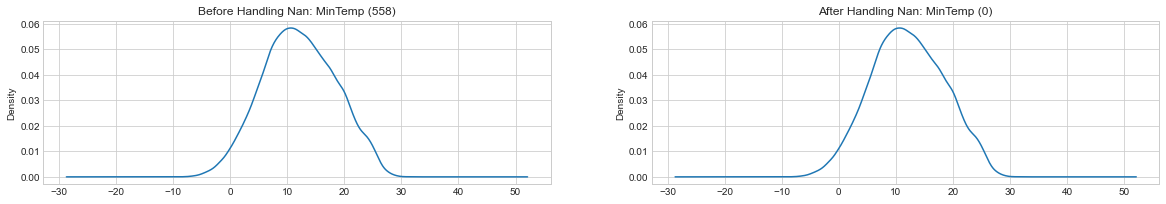

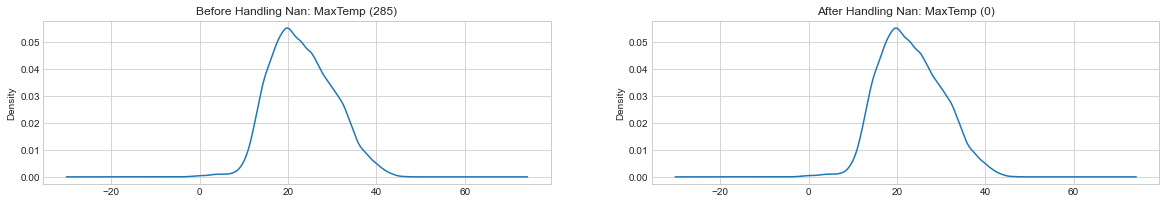

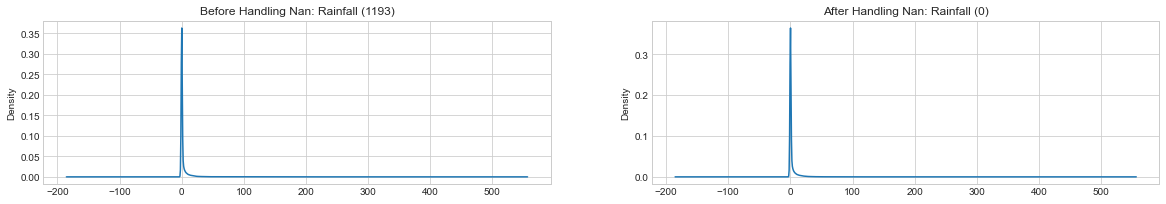

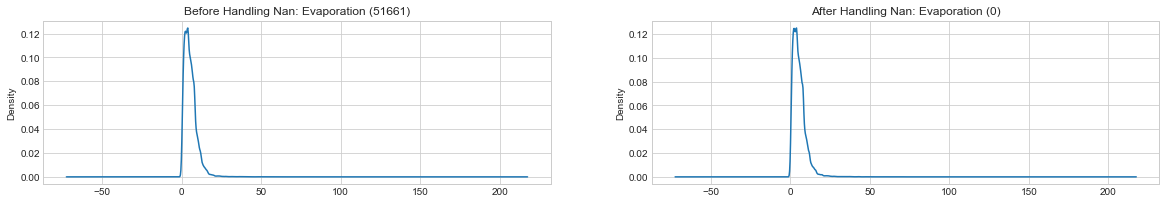

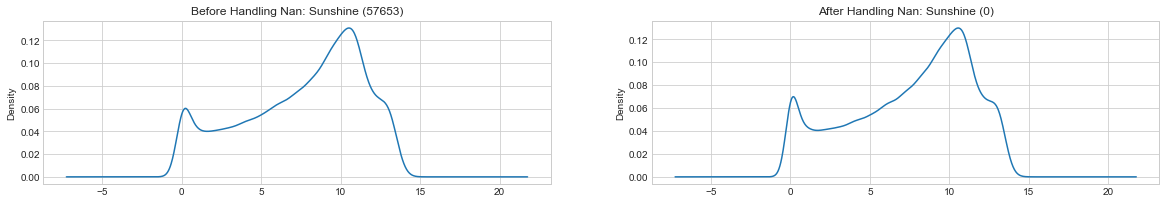

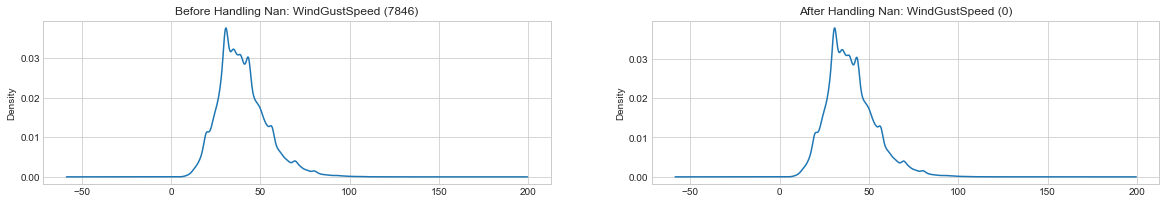

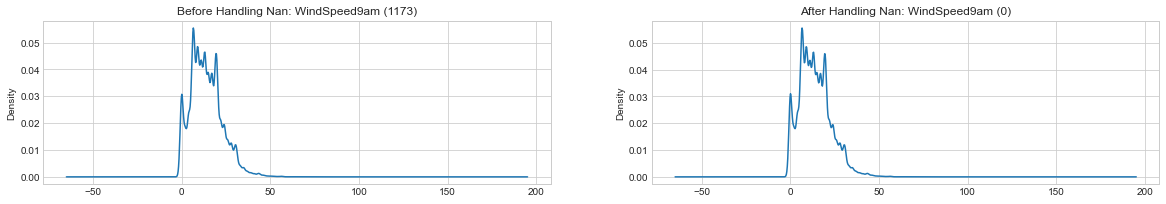

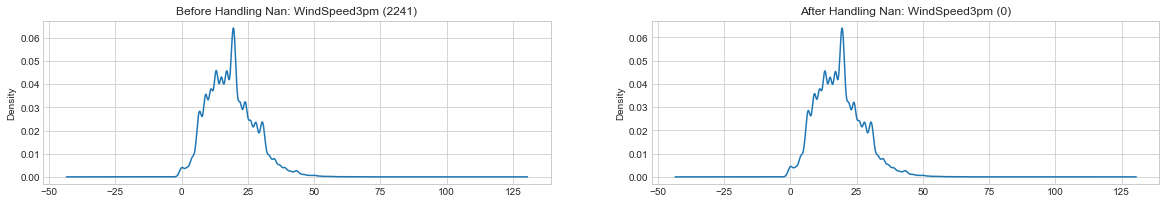

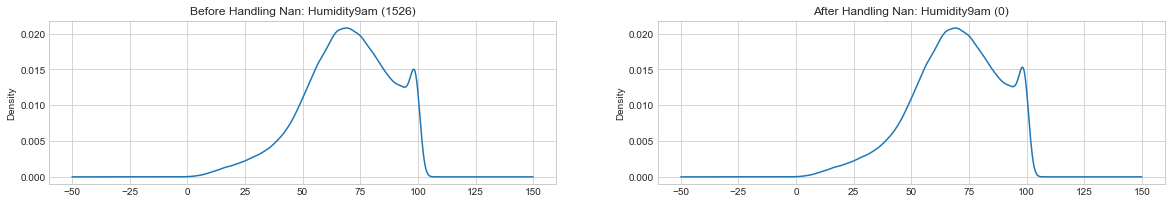

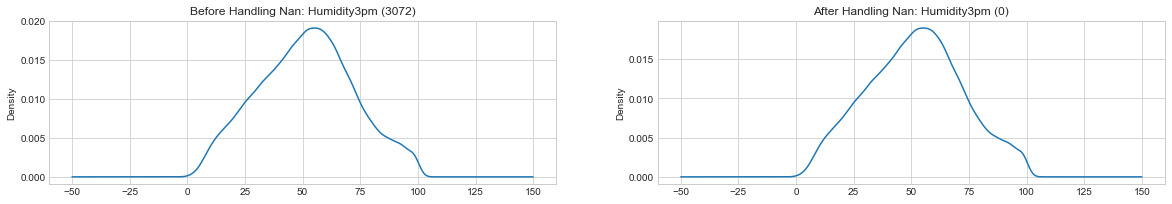

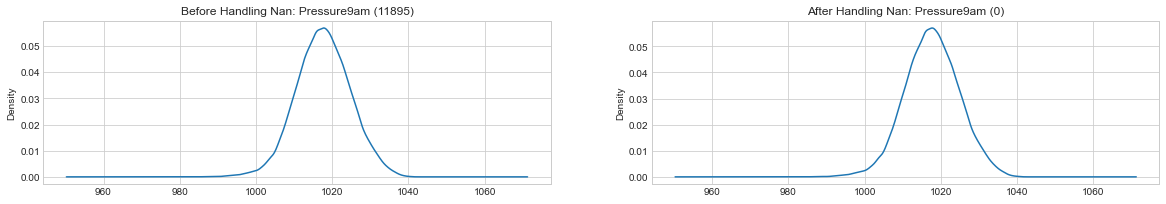

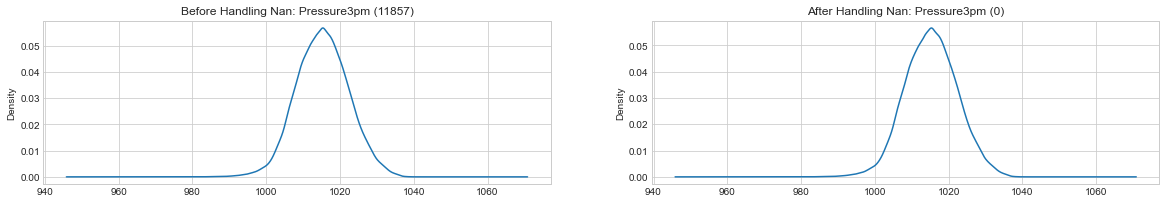

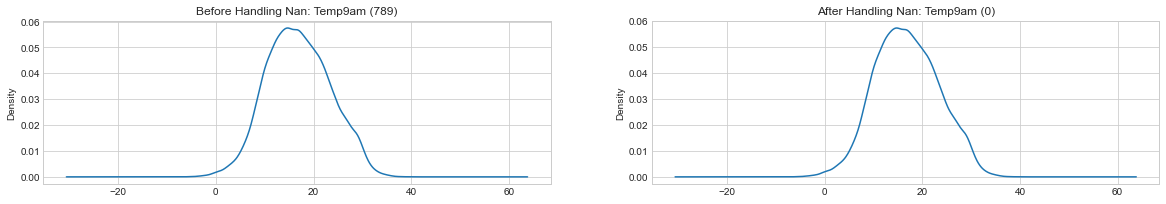

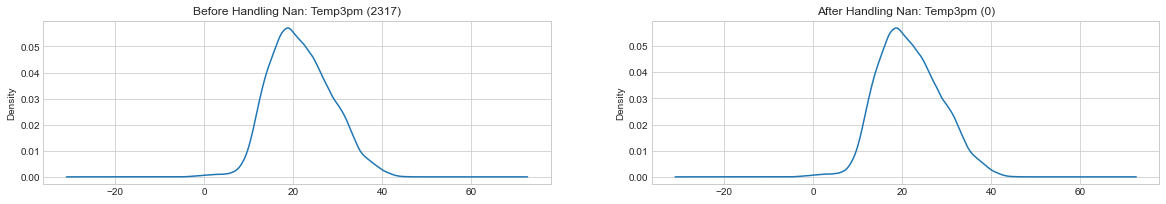

In [23]:
# Checking kde plot before/after treating null values
# to see how much things have changed.

for e, i in enumerate(num_cols):
    if df[i].isnull().sum() != 0:
        plt.figure(figsize = (20, 50))

        plt.subplot(len(num_cols), 2, 2*e+1)
        plt.title(f'Before Handling Nan: {i} ({df[i].isnull().sum()})')
        df[i].plot(kind = 'kde')

        plt.subplot(len(num_cols), 2, 2*e+2)
        plt.title(f'After Handling Nan: {i} ({df1[i].isnull().sum()})')
        df1[i].plot(kind = 'kde')

        plt.show()

### Deriving extra features

In [24]:
def form_group(df, num_cols):
    
    def get_grp(x):
        if x <= (mean - 3*std):
            return 0
        elif (x > (mean - 3*std)) & (x <= (mean - 2*std)):
            return 1
        elif (x > (mean - 2*std)) & (x <= (mean - std)):
            return 2
        elif (x > (mean - std)) & (x <= mean):
            return 3
        elif (x > mean) & (x <= (mean + std)):
            return 4
        elif (x > (mean + std)) & (x <= (mean + 2*std)):
            return 5
        elif (x > (mean + 2*std)) & (x <= (mean + 3*std)):
            return 6
        else:
            return 7
            
     
    for nc in num_cols:
        mean = np.mean(df[nc])
        std = np.std(df[nc])
        df[f'{nc}_grp'] = df[nc].apply(get_grp)
    
    return df

    

df1 = form_group(df1.copy(), num_cols) # Training Data
Valdf_2 = form_group(Valdf_1.copy(), num_cols) # Val data


for i in df1.columns:
    if i not in cat_cols:
        if i.endswith('grp'):
            cat_cols.append(i)

### Handling Outliers

In [25]:
class Outlier(object):
    def __init__(self, df):
        self._df = df
        self.__extract_info
        
    @property
    def __extract_info(self):
        self.info = {}
        for col in self._df.columns:
            if self._df[col].dtype.name in ['int32', 'int64', 'float32', 'float64']:
                self.info[col] = {}
                self.info[col]['min'] = self._df[col].min()
                self.info[col]['max'] = self._df[col].max()
                self.info[col]['mean'] = self._df[col].mean()
                self.info[col]['median'] = self._df[col].median()
                self.info[col]['mode'] = self._df[col].mode().values
                self.info[col]['std'] = self._df[col].std()
                self.info[col]['quantile_1'] = self._df[col].quantile(q = 0.25)
                self.info[col]['quantile_3'] = self._df[col].quantile(q = 0.75)
                self.info[col]['iqr'] = self.info[col]['quantile_3'] - self.info[col]['quantile_1']
                self.info[col]['percentile_x'] = lambda x: np.percentile(col, x*100)
                
    
                
class IQR(Outlier):
    def __init__(self, df, t = 1.5):
        super().__init__(df)
        self.t = t
        self.df = self._df
        
    def get_bounds(self, col):
        lower_bound = self.info[col]['quantile_1'] - self.t * self.info[col]['iqr']
        upper_bound = self.info[col]['quantile_3'] + self.t * self.info[col]['iqr']
        return lower_bound, upper_bound
        
    def remove(self, cols):
        for col in cols:
            lower_bound, upper_bound = self.get_bounds(col)
            self.df = self.df.loc[(self.df[col] > lower_bound) & (self.df[col] < upper_bound)]
            
        return self.df
            
    def adjust(self, cols):
        for col in cols:
            lower_bound, upper_bound = self.get_bounds(col)
            self.df.loc[self.df[col] <= lower_bound, col] = lower_bound
            self.df.loc[self.df[col] >= upper_bound, col] = upper_bound
            
        return self.df
    
    
class Z_Score(Outlier):
    def __init__(self, df, thresh = 3):
        super().__init__(df)
        self.df = self._df
        self.thresh = thresh
        
    def get_z_score(self, col):
        return (self.df[col] - self.info[col]['mean']) / self.info[col]['std']
        
    def remove(self, cols):
        for col in cols:
            self.df[f'{col}_z'] = self.get_z_score(col)
            self.df = self.df[(self.df[f'{col}_z'] > -self.thresh) & (self.df[f'{col}_z'] < self.thresh)]
            self.df = self.df.drop(f'{col}_z', axis = 1)
            
        return self.df
    
    def adjust(self, cols):
        for col in cols:
            self.df[f'{col}_z'] = self.get_z_score(col)
            self.df[col]
            
            self.df.loc[self.df[f'{col}_z'] <= -self.thresh, col] = self.df.loc[self.df[f'{col}_z'] > -self.thresh,
                                                                                col].values.min()
            self.df.loc[self.df[f'{col}_z'] >= self.thresh, col] = self.df.loc[self.df[f'{col}_z'] < self.thresh,
                                                                               col].values.max()
            self.df = self.df.drop(f'{col}_z', axis = 1)
            
        return self.df
    
class StandardDeviation(Outlier):
    def __init__(self, df, thresh = 3):
        super().__init__(df)
        self.df = df
        self.thresh = thresh
        
    def get_bounds(self, col):
        mean, std = self.info[col]['mean'], self.info[col]['std']
        l_std, u_std = mean - std * self.thresh, mean + std * self.thresh
        return l_std, u_std
        
    def remove(self, cols):
        for col in cols:
            l_std, u_std = self._get_bounds(col)
            self.df = self.df.loc[(self.df[col] > l_std) & (self.df[col] < u_std)]
        return self.df
            
    def adjust(self, cols):
        for col in cols:
            l_std, u_std = self._get_bounds(col)
            self.df.loc[self.df[col] <= l_std, col] = l_std
            self.df.loc[self.df[col] >= u_std, col] = u_std
        return self.df
            
class Percentile(Outlier):
    def __init__(self, df, p_range = [0.05, 0.95]):
        super().__init__(df)
        self.df = df
        self.p_range = p_range
        assert (p_range[0] >= 0.0) & (p_range[1] <= 1.0), '`p_ranges` must be between [0, 1].'
        
    def get_percentiles(self, col):
        lp, up = self.info[col]['percentile_x'](self.p_range[0]), self.info[col]['percentile_x'](self.p_range[1])
        return lp, up
    
    def remove(self, cols):
        for col in cols:
            lp, up = self.get_percentiles(col)
            self.df = self.df.loc[(self.df[col] > lp) & (self.df[col] < up)]
        return self.df
    
    def adjust(self, cols):
        for col in cols:
            lp, up = self.get_percentiles(col)
            self.df.loc[self.df[col] <= lp, col] = lp
            self.df.loc[self.df[col] >= up, col] = up
        return self.df

In [27]:
# Treating Outliers
df2 = df1.copy()

iqr = IQR(df2.copy())
df2 = iqr.remove(num_cols)

iqr = IQR(Valdf_2.copy())
Valdf_3 = iqr.adjust(num_cols)

df2.shape, Valdf_3.shape

((85452, 42), (20262, 42))

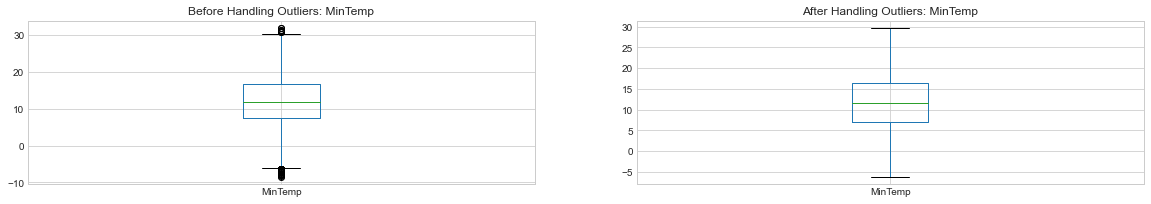

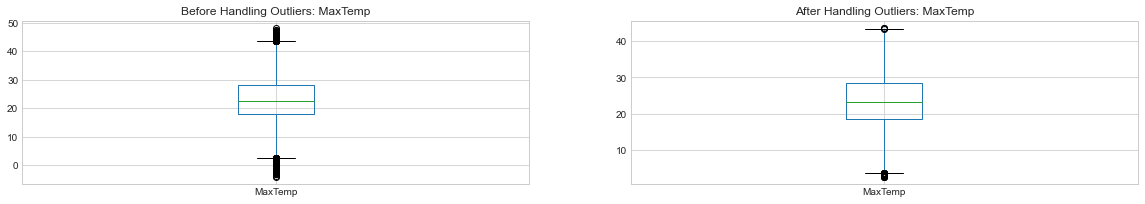

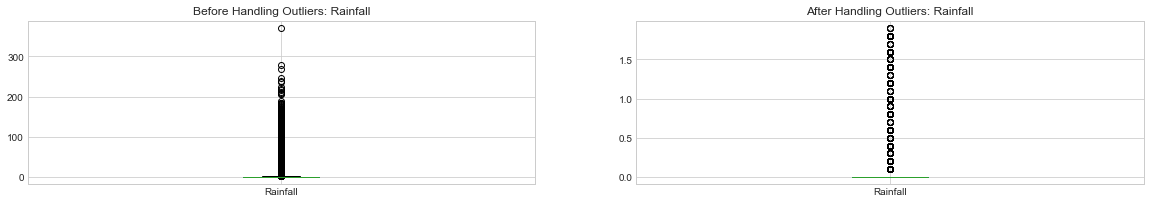

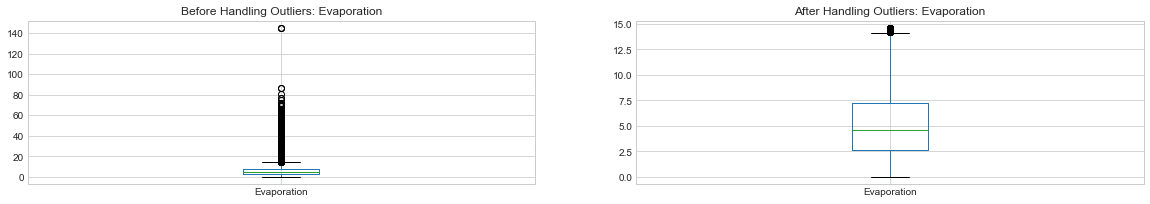

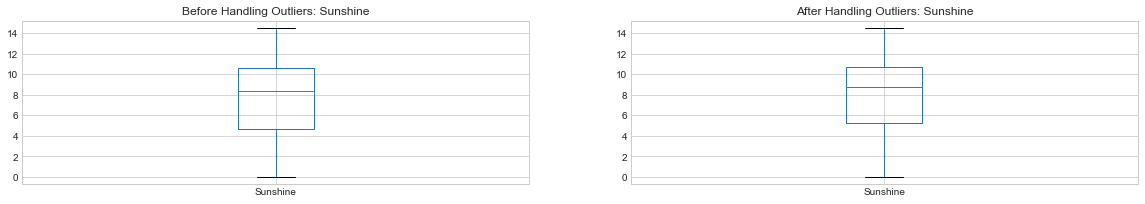

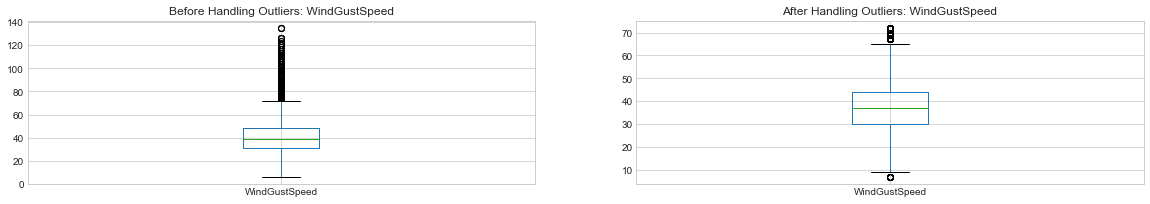

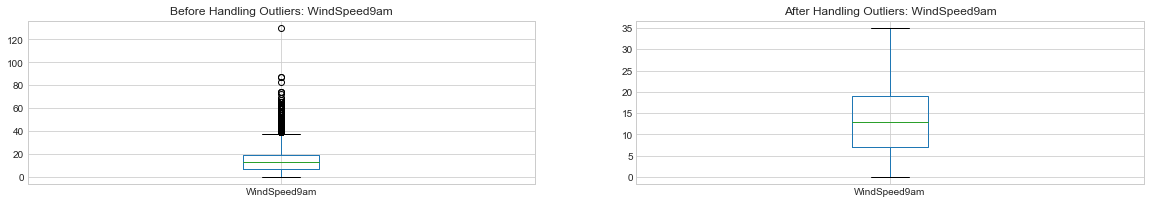

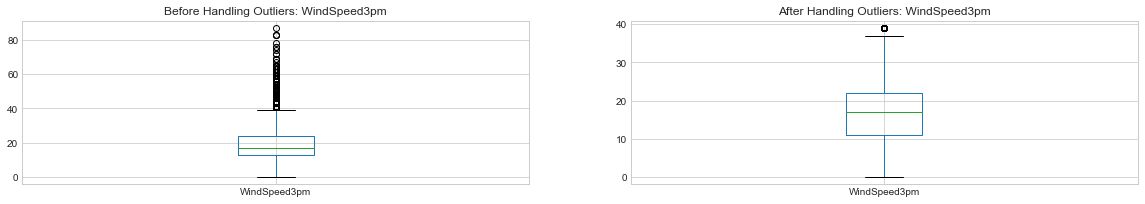

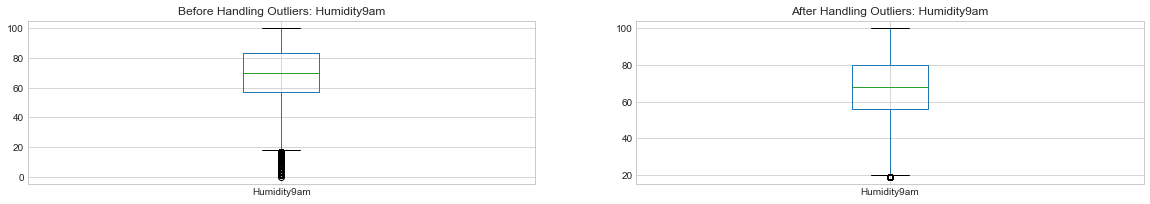

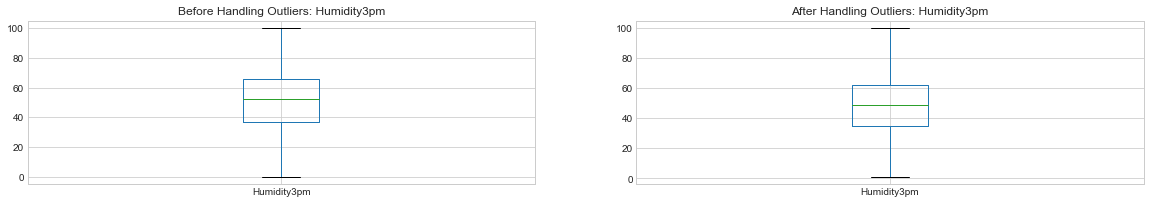

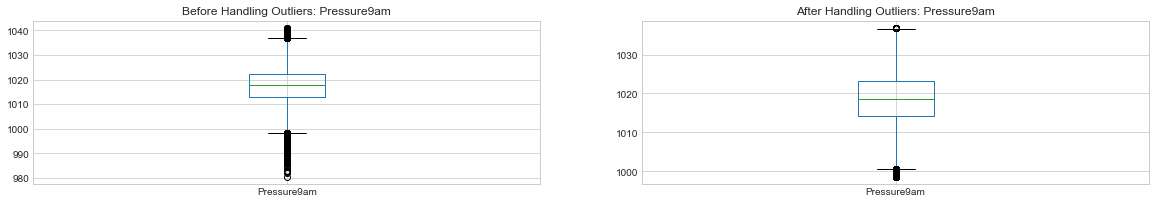

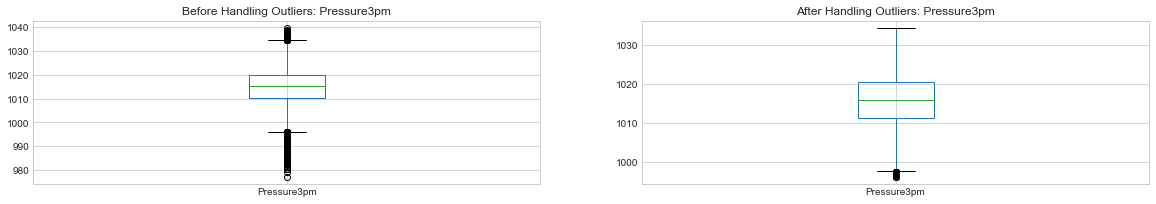

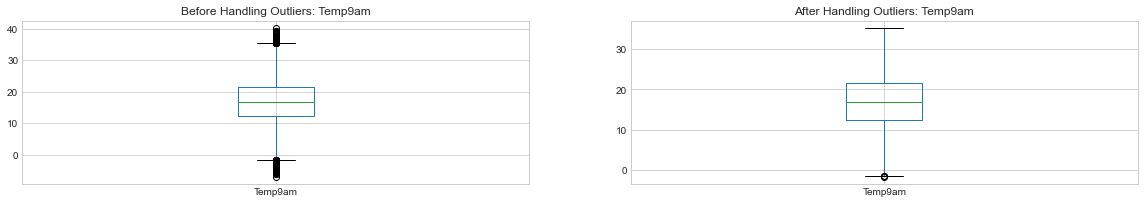

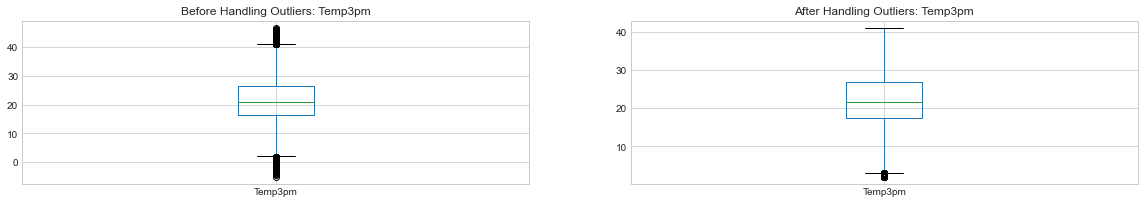

In [28]:
# Checking box plot before/after treating outliers
# to see how much things have changed.

for e, i in enumerate(num_cols):
    plt.figure(figsize = (20, 50))
    
    plt.subplot(len(num_cols), 2, 2*e+1)
    plt.title(f'Before Handling Outliers: {i}')
    df1.boxplot(i)

    plt.subplot(len(num_cols), 2, 2*e+2)
    plt.title(f'After Handling Outliers: {i}')
    df2.boxplot(i)

    plt.show()

### Univariate, Bivariate & Multivariate Analysis

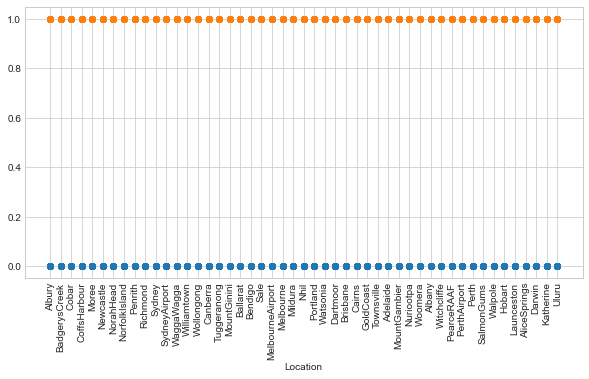

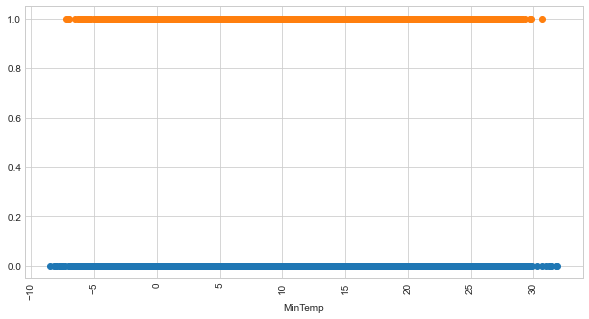

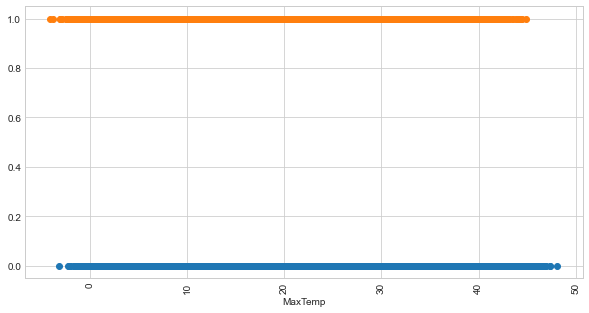

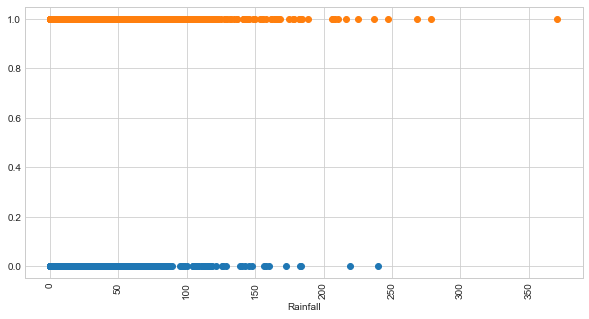

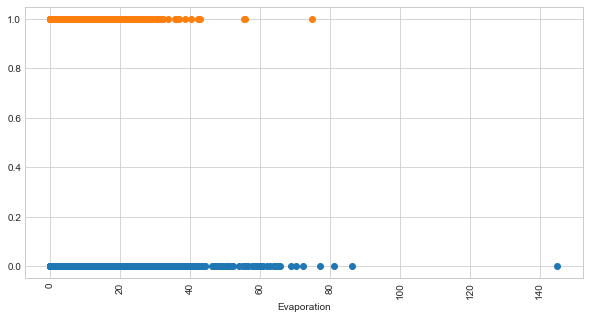

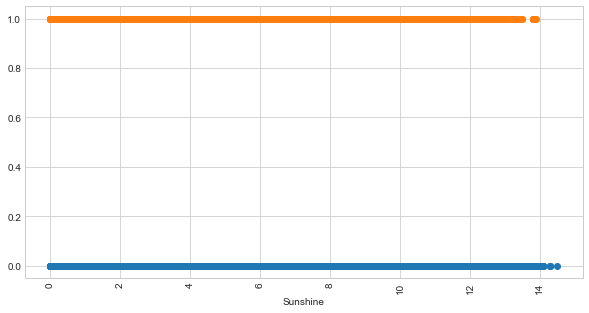

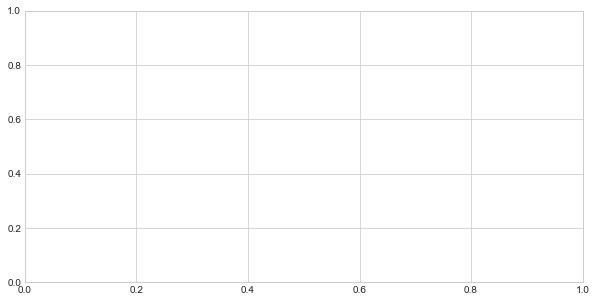

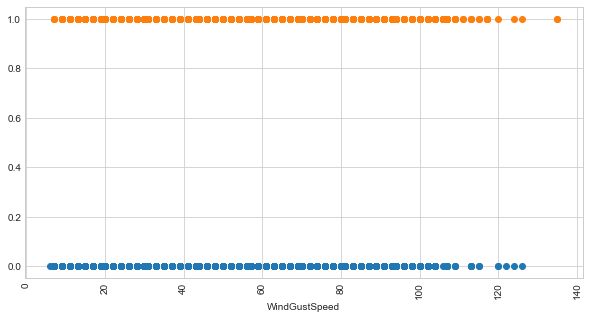

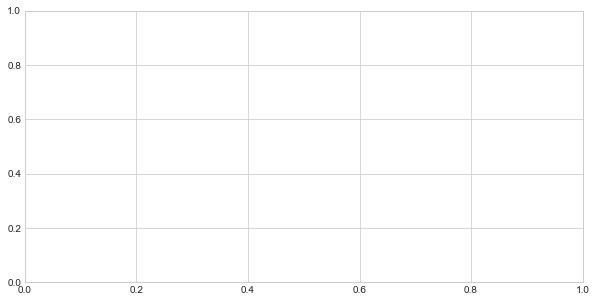

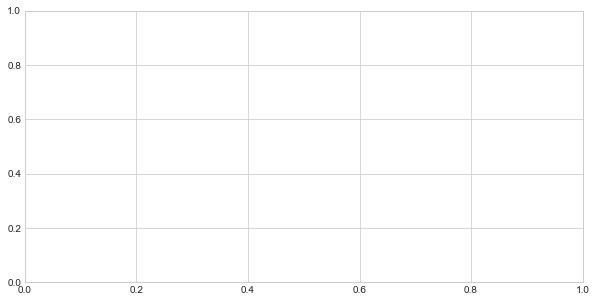

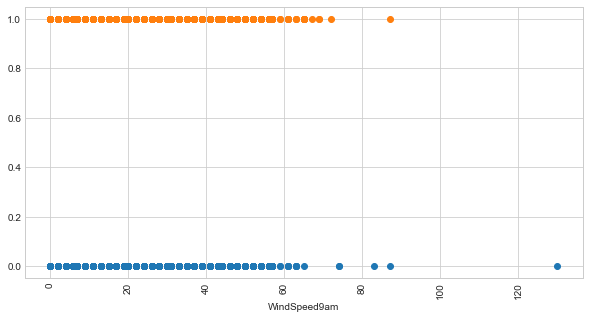

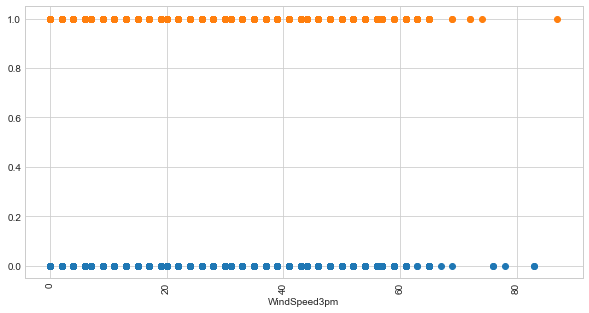

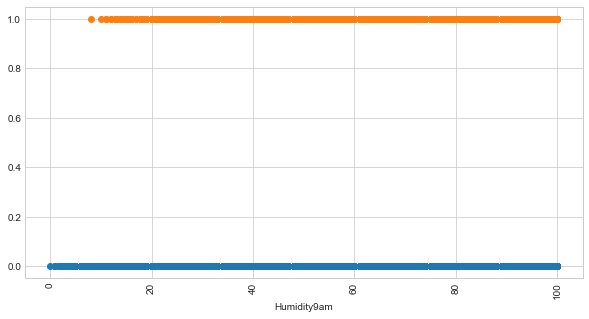

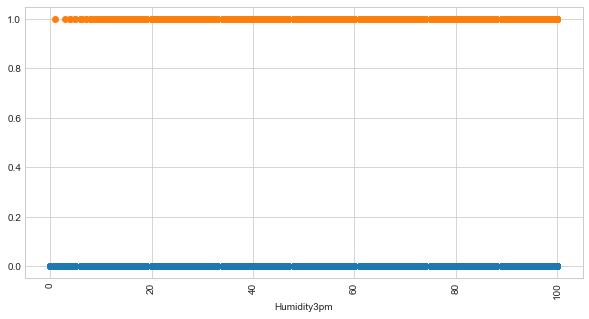

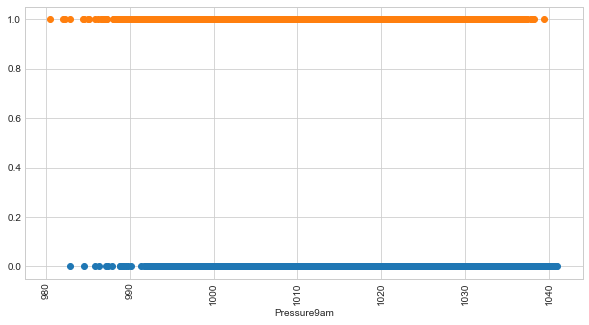

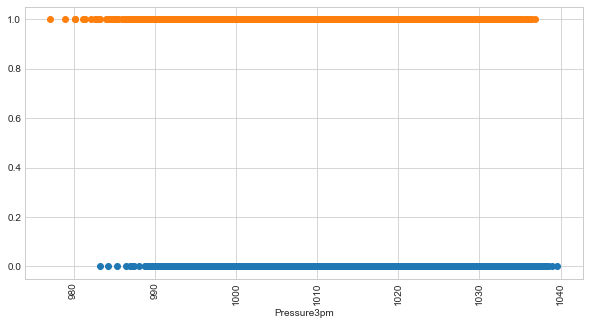

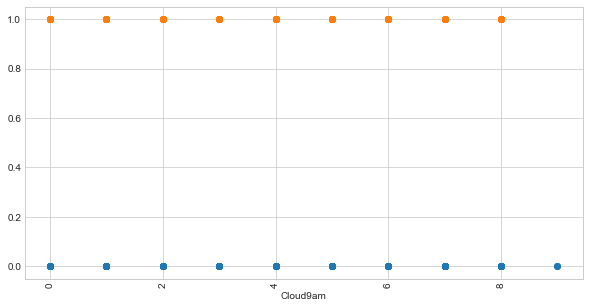

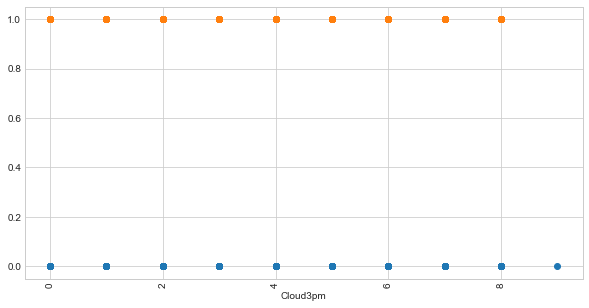

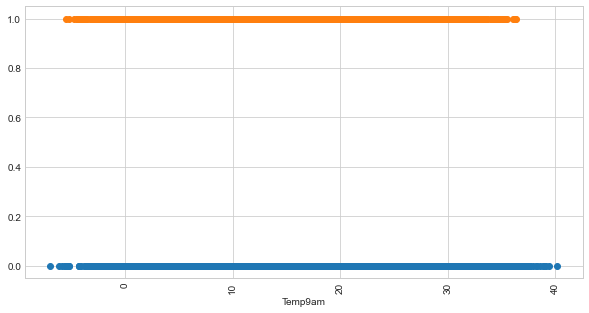

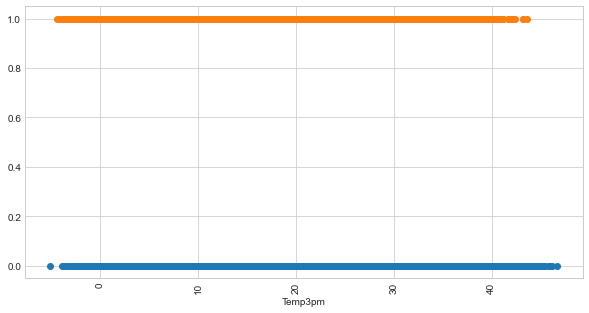

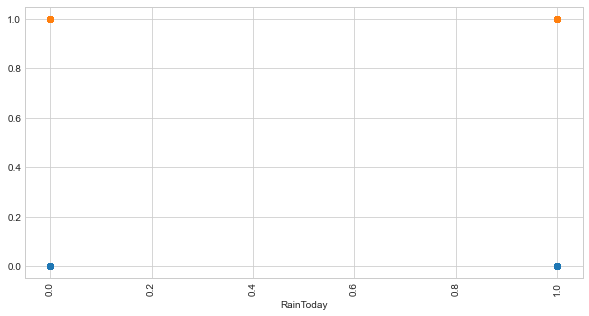

In [58]:
for ucol in df.columns[6:-1]:
    try:
        plt.figure(figsize = (10, 5))
        
        plt.plot(df.loc[df['RainTomorrow'] == 0, ucol], np.zeros_like(df.loc[df['RainTomorrow'] == 0, ucol]), 'o')
        plt.plot(df.loc[df['RainTomorrow'] == 1, ucol], np.ones_like(df.loc[df['RainTomorrow'] == 1, ucol]), 'o')

        plt.xlabel(ucol)
        plt.xticks(rotation = 90)
        plt.show()
    except:
        pass

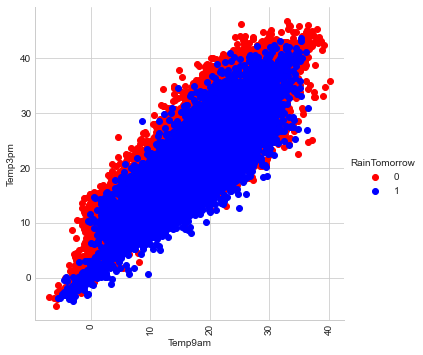

In [59]:
sns.FacetGrid(df, hue = 'RainTomorrow', height = 5, palette = ['red', 'blue'], 
                              subplot_kws = {'alpha': 0.9, 'fc':'white'}).map_dataframe(plt.scatter, 
                                                                 'Temp9am', 
                                                                 'Temp3pm').add_legend()

plt.xticks(rotation = 90)
plt.show()

In [60]:
# plt.figure(figsize = (10, 10))
# sns.pairplot(df)
# plt.show()

### Some Basic EDA

In [61]:
# Using the original data for exploratory data analysis

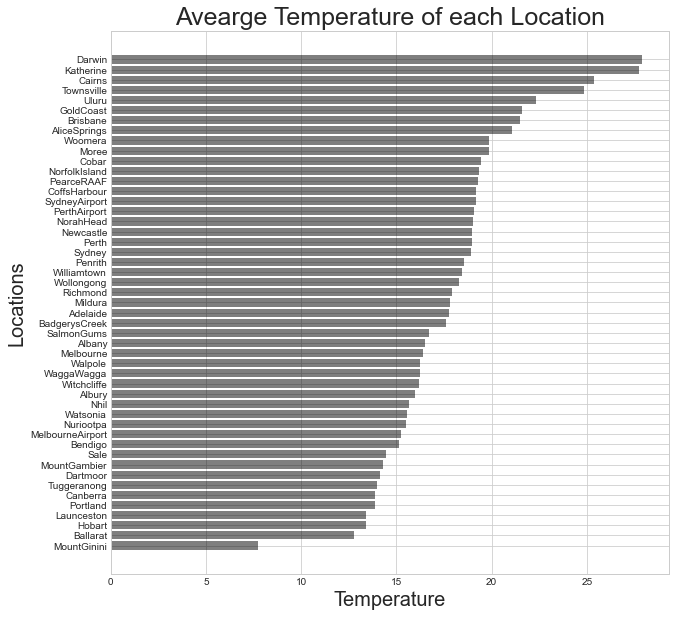

In [62]:
plt.figure(figsize = (10, 10))
df['avg_temp'] = 0.5 * (df['MinTemp'] + df['MaxTemp'])
loc_mnt = df.groupby('Location')['avg_temp'].mean().sort_values()

plt.barh(loc_mnt.index, loc_mnt.values, alpha = 0.5, color = 'black')
plt.title('Avearge Temperature of each Location', fontsize = 25)
plt.xlabel('Temperature', fontsize = 20)
plt.ylabel('Locations', fontsize = 20)

df.drop('avg_temp', axis = 1, inplace = True)
plt.show()

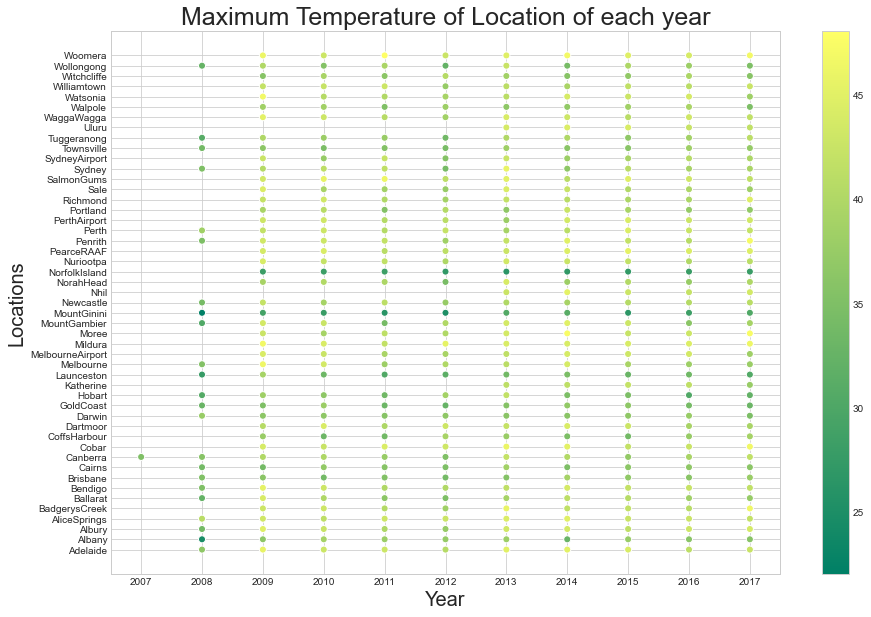

In [63]:
plt.figure(figsize = (15, 10))
f = df.groupby(['Location', 'Year'])['MaxTemp'].max().reset_index()

plt.scatter(f['Year'], f['Location'], c = f['MaxTemp'], cmap = 'summer', edgecolors='white', s = 50)

plt.title('Maximum Temperature of Location of each year', fontsize = 25)
plt.xlabel('Year', fontsize = 20)
plt.ylabel('Locations', fontsize = 20)

# plt.grid(True)
plt.xticks(f['Year'].unique())
plt.colorbar()
plt.show()

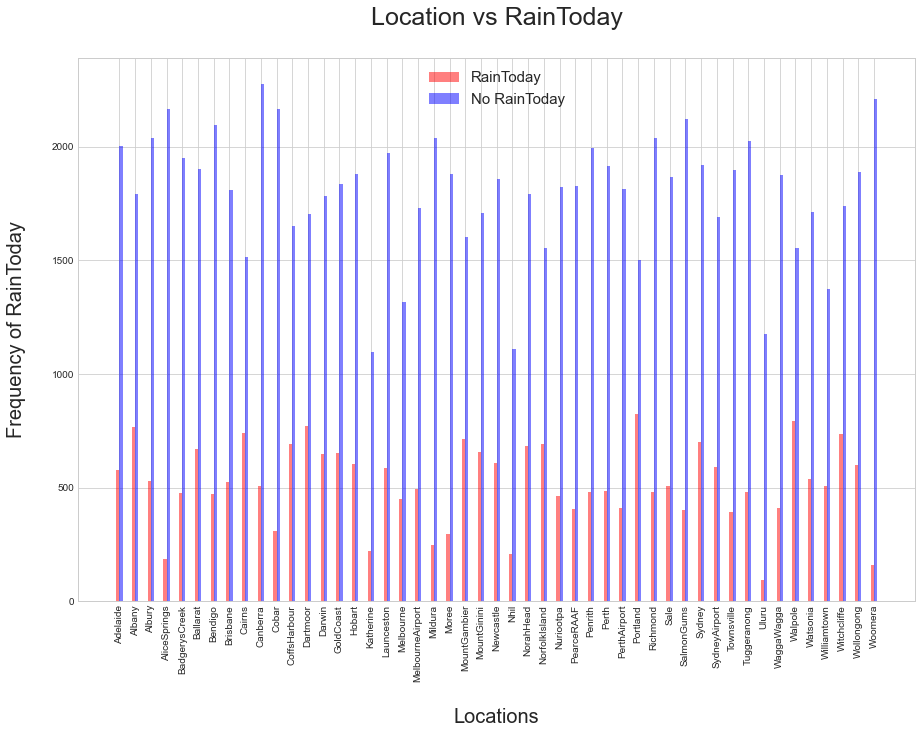

In [64]:
r = df.groupby(['Location', 'RainToday'])['RainToday'].count().unstack().reset_index()

plt.figure(figsize = (15, 10))

xloc = np.arange(len(r['Location']))
width = 0.2

plt.bar(xloc - width/2, r[1.0], width = width, label = 'RainToday', color = 'red', alpha = 0.5)
plt.bar(xloc + width/2, r[0.0], width = width, label = 'No RainToday', color = 'blue', alpha = 0.5)

plt.title('Location vs RainToday\n', fontsize = 25)
plt.xlabel('\nLocations', fontsize = 20)
plt.ylabel('Frequency of RainToday\n', fontsize = 20)

plt.xticks(xloc, r['Location'], rotation = 90)
plt.legend(loc = 'upper center', fontsize = 15)
plt.show()

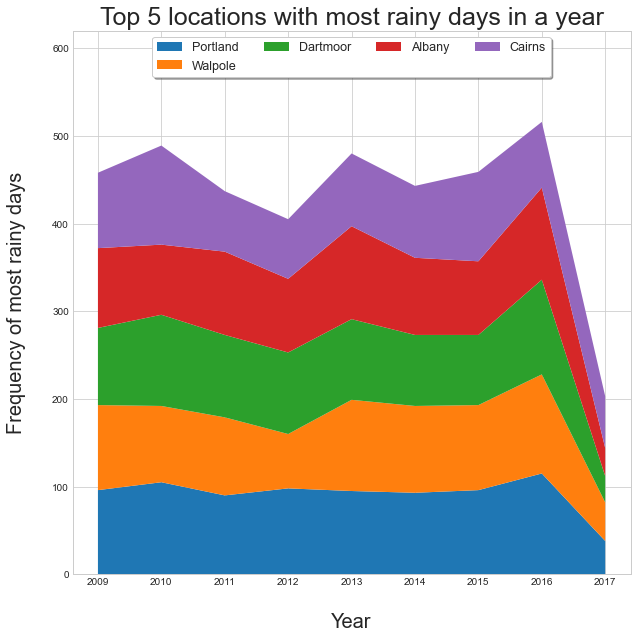

In [65]:
r = df.groupby(['Location', 'Year'])['RainToday'].sum().unstack().reset_index()#.dropna(axis = 1)
rr = r.iloc[list(r.iloc[:, 1:].sum(axis = 1).nlargest(5).index), :].dropna(axis = 1)

plt.figure(figsize = (10, 10))
plt.stackplot(rr.columns[1:].astype('int'), np.array(rr.iloc[:, 1:]), labels = rr['Location'], baseline='zero')

plt.legend(ncol = 4, loc = 'upper center', frameon = True, shadow = True, fontsize = 12.5)

plt.title('Top 5 locations with most rainy days in a year', fontsize = 25)
plt.xlabel('\nYear', fontsize = 20)
plt.ylabel('Frequency of most rainy days\n', fontsize = 20)

plt.ylim(0, 620)
plt.show()

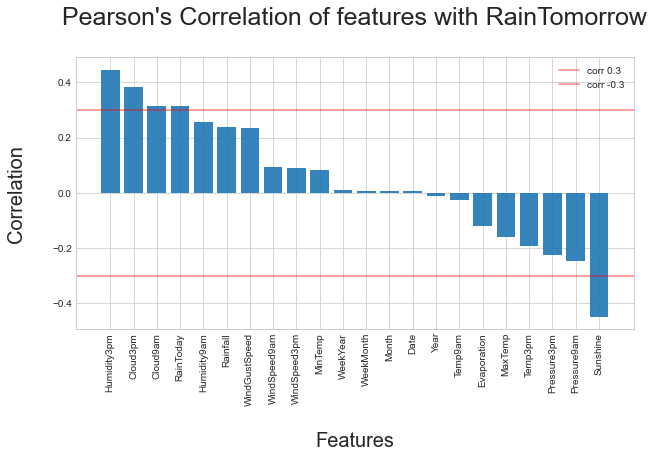

In [66]:
corr_rt = df.corr()['RainTomorrow'].sort_values(ascending = False)[1:]

plt.figure(figsize = (10, 5))
plt.bar(corr_rt.index, corr_rt.values, alpha = 0.9)
plt.axhline(0.3, color = 'red', alpha = 0.5, label = 'corr 0.3')
plt.axhline(-0.3, color = 'red', alpha = 0.5, label = 'corr -0.3')

plt.title('Pearson\'s Correlation of features with RainTomorrow\n', fontsize = 25)
plt.xlabel('\nFeatures', fontsize = 20)
plt.ylabel('Correlation\n', fontsize = 20)
plt.xticks(rotation = 90)
plt.legend()
plt.show()

### Handling Imbalanced Data

In [67]:
df2['RainTomorrow'].value_counts(normalize=True)

0    0.840952
1    0.159048
Name: RainTomorrow, dtype: float64

In [68]:
cat_feat_idx = []
for e, i in enumerate(df2.drop('RainTomorrow', axis = 1).columns):
    if i in cat_cols:
        cat_feat_idx.append(e)
        
# cat_feat_idx

In [69]:
smote = SMOTENC(cat_feat_idx)

In [70]:
sm = smote.fit_resample(df2.drop('RainTomorrow', axis = 1), df2.loc[:, 'RainTomorrow'])

In [71]:
sm[1].value_counts(normalize=True)

0    0.5
1    0.5
Name: RainTomorrow, dtype: float64

In [72]:
df3 = sm[0].copy()
df3['RainTomorrow'] = sm[1].copy()

In [73]:
df3.shape

(143722, 42)

In [74]:
vtr = Valdf_3['RainTomorrow']
Valdf_3.drop('RainTomorrow', axis = 1, inplace = True)
Valdf_3['RainTomorrow'] = vtr

### Model Creation (Before Feature Selection)

In [104]:
trans_col = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown = 'ignore'), cat_cols),
    ('standard_scaler', StandardScaler(), num_cols)
])
pipe = Pipeline([
    ('column_transformer', trans_col), 
    ('model', DecisionTreeClassifier()),
])

In [105]:
pipe.fit(df3.iloc[:, :-1], df3.iloc[:, -1])

Pipeline(steps=[('column_transformer',
                 ColumnTransformer(transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Year', 'Month', 'Date',
                                                   'WeekYear', 'WeekDay',
                                                   'WeekMonth', 'Location',
                                                   'WindGustDir', 'WindDir9am',
                                                   'WindDir3pm', 'Cloud9am',
                                                   'Cloud3pm', 'RainToday',
                                                   'MinTemp_grp', 'MaxTemp_grp',
                                                   'Rainfall_grp',
                                                   'Evaporation_grp',
                                                   'Sunshine_grp',
                                                   'WindGustSpeed_gr..

In [106]:
(pipe.predict(df3.iloc[:, :-1]) == df3.iloc[:, -1]).mean()

1.0

In [110]:
print((pipe.predict(Valdf_3.dropna().iloc[:, :-1]) == Valdf_3.dropna().iloc[:, -1]).mean())

0.7431151909979271


### Feature Scaling (Transformation)

In [112]:
class Transformations(object):
    def __init__(self, df):
        self.df = df
        
    def standardize(self, col):
        mean = np.mean(self.df[col])
        std = np.std(self.df[col]) + 1e-12
        return (self.df[col] - mean) / std
    
    def normalize(self, col):
        norm = np.sqrt(np.sum(np.square(self.df[col])))
        return self.df[col]/norm
    
    def minmax(self, col):
        min_ = np.min(self.df[col])
        max_ = np.max(self.df[col])
        return (self.df[col] - min_)/(max_ - min_)
    
    def log10(self, col):
        if 0 in self.df[col].unique():
            return np.log10(self.df[col] + 1)
        return np.log10(self.df[col])
    
    def log(self, col):
        if 0 in self.df[col].unique():
            return np.log(self.df[col] + 1)
        return np.log(self.df[col])
    
    def boxcox(self, col):
        if 0 in self.df[col].unique():
            return boxcox(self.df[col] + 1)[0]
        return boxcox(self.df[col])[0]
    
    def sqrt(self, col):
        return np.sqrt(self.df[col])
    
    def reciprocal(self, col):
        return 1/np.where(self.df[col] == 0, 1e-12, self.df[col])
    
    def power(self, col, pow_):
        return self.df[col] ** pow_
    
    def med_quant_scale(self, col):
        median = np.median(self.df[col])
        iqr = np.quantile(self.df[col], 0.75) - np.quantile(self.df[col], 0.25)
        return (self.df[col] - median)/iqr

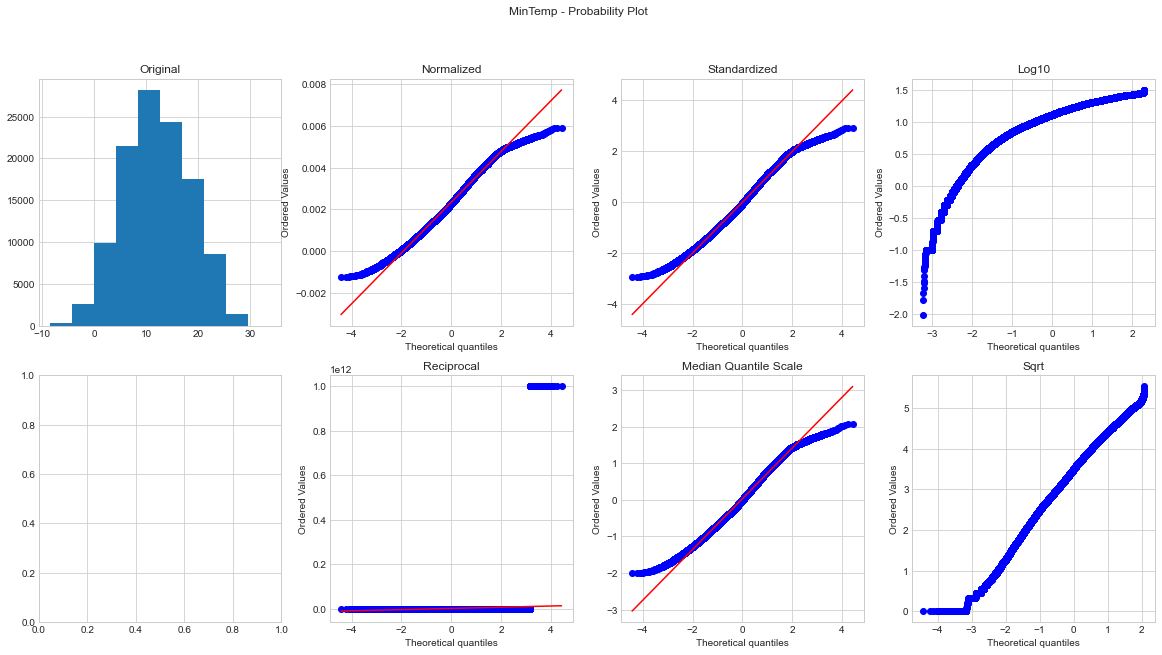

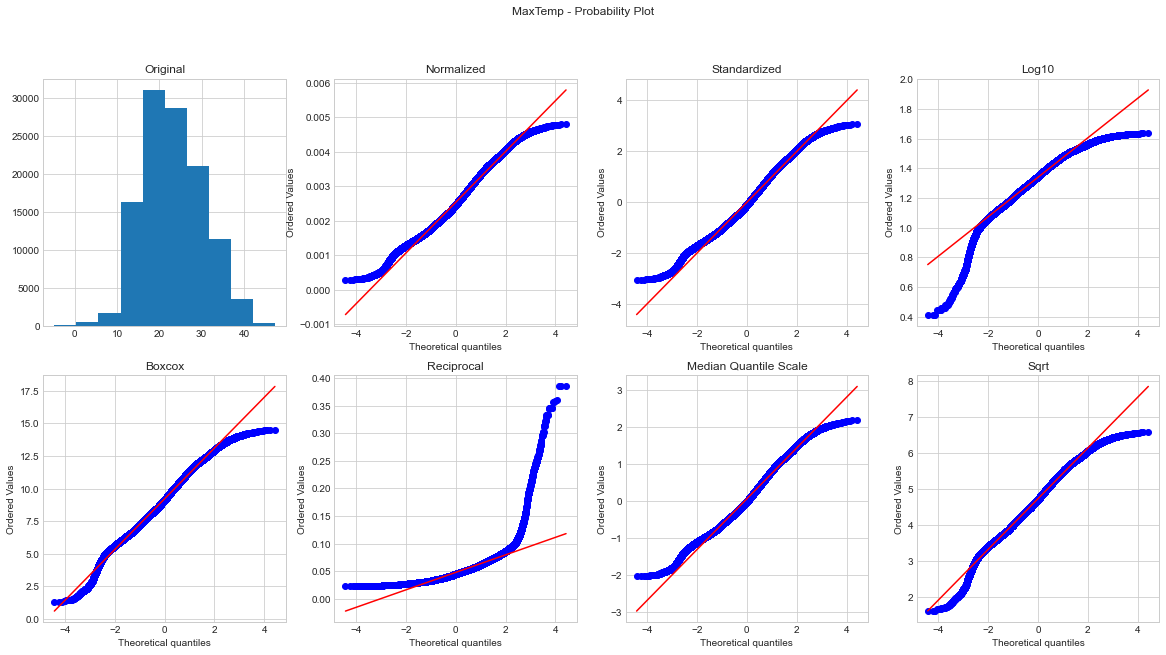

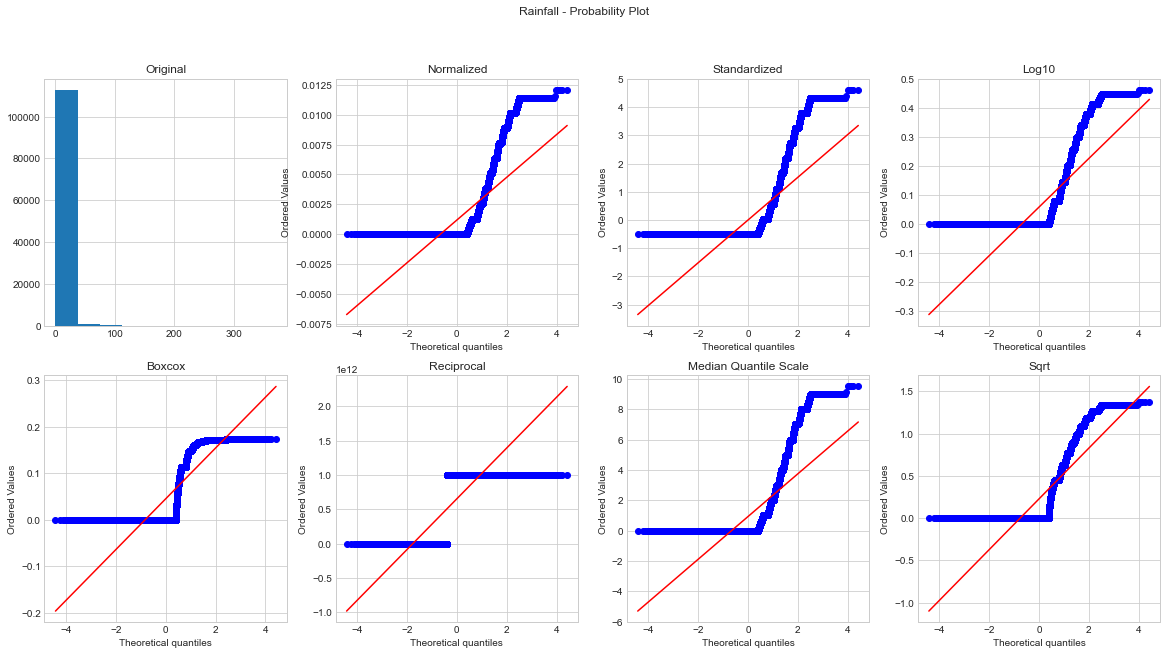

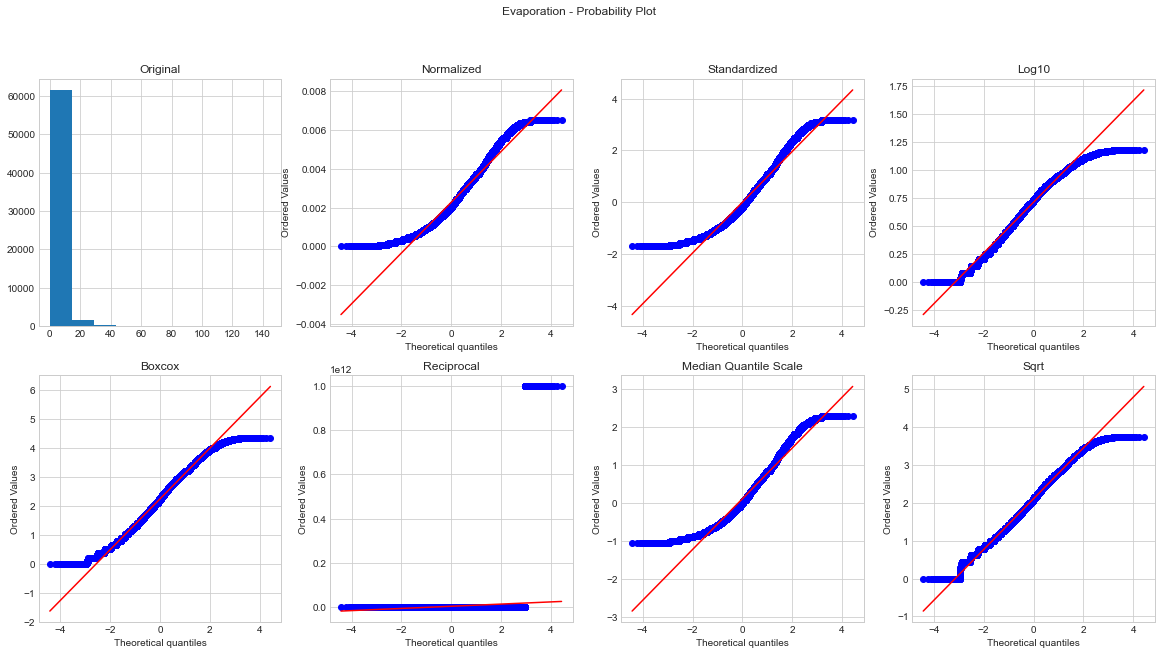

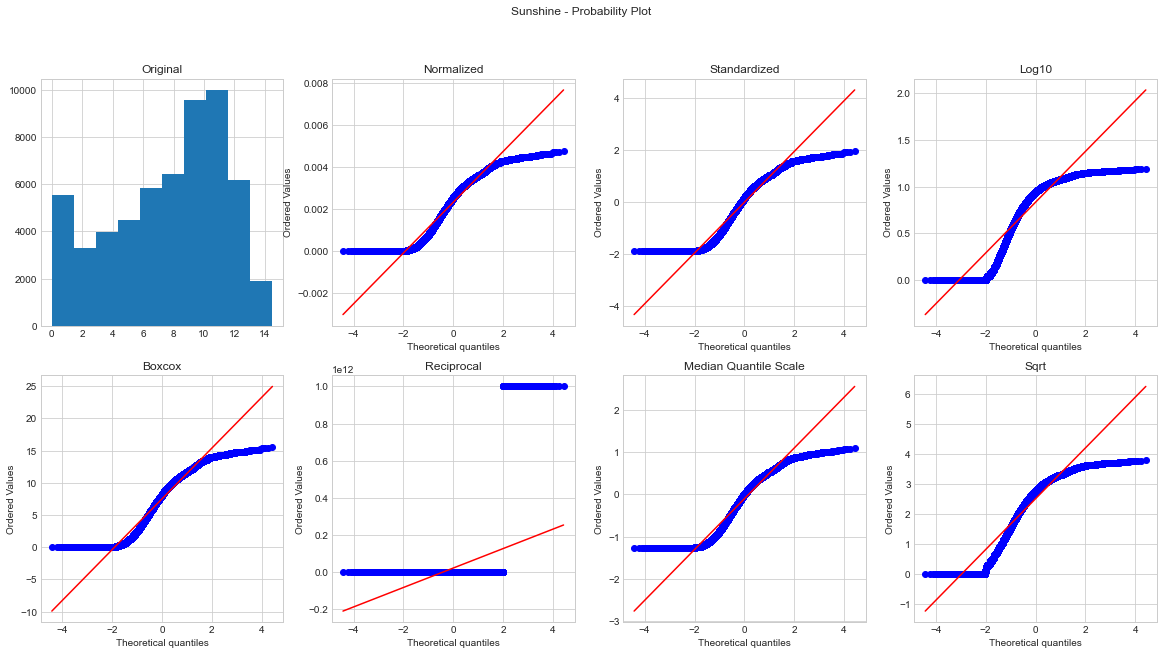

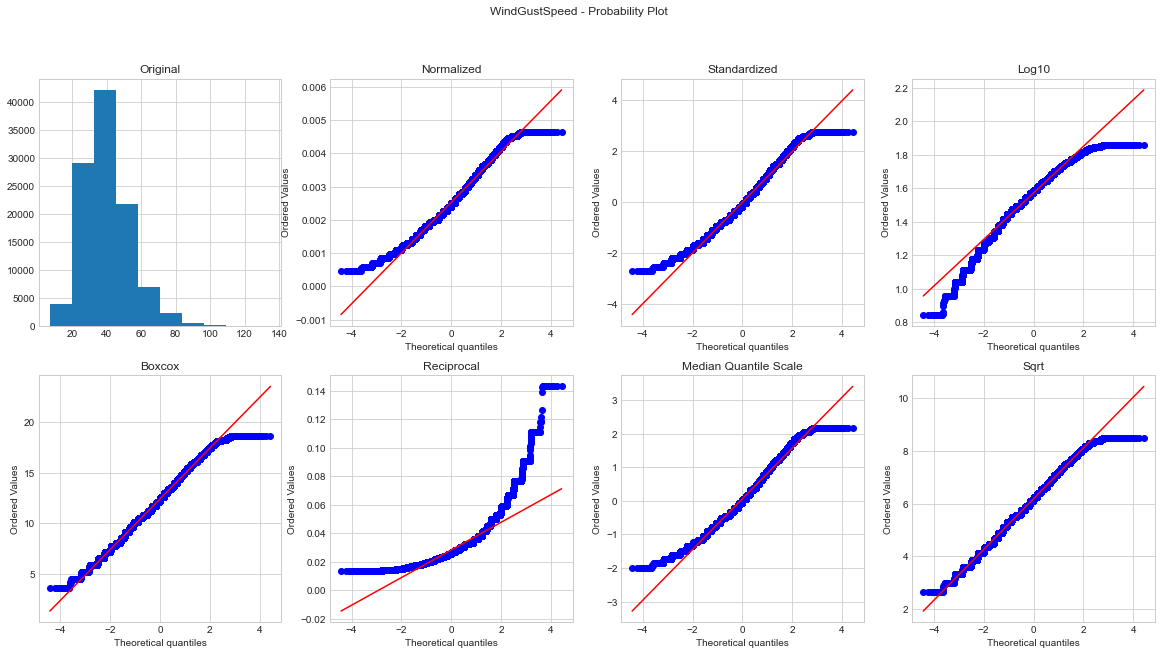

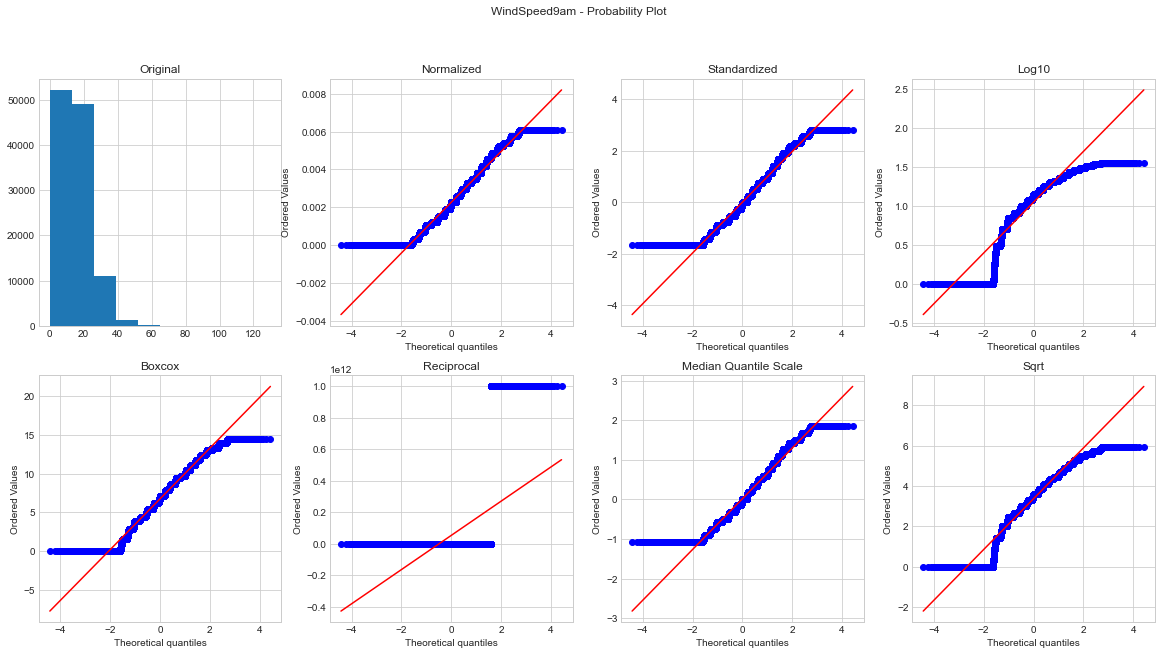

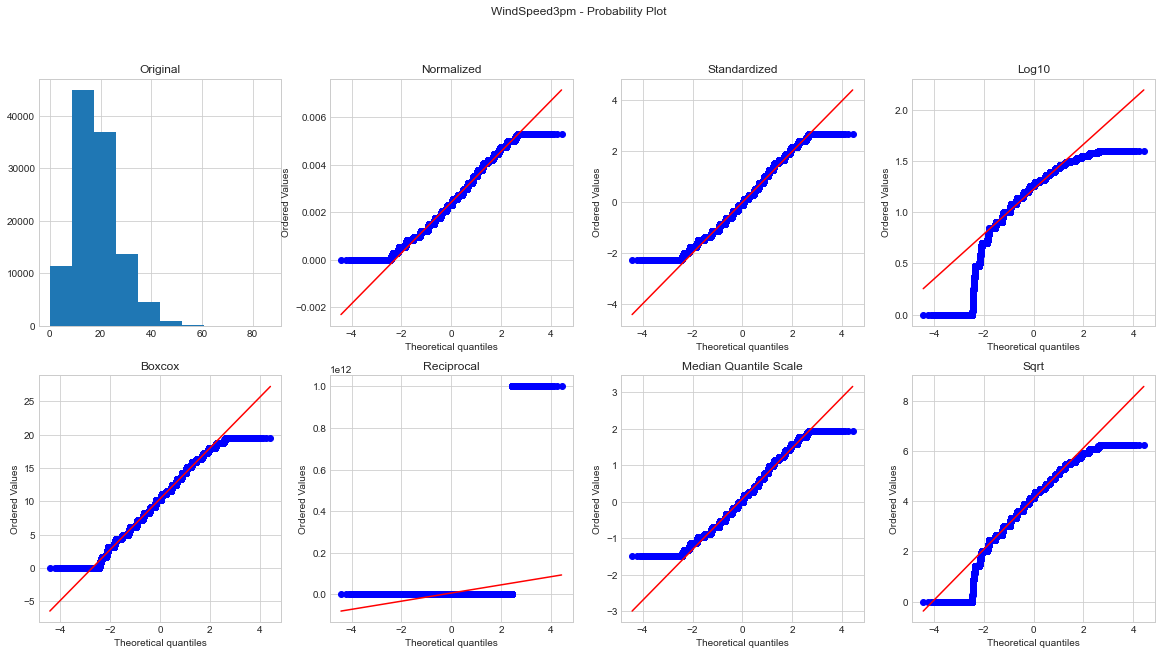

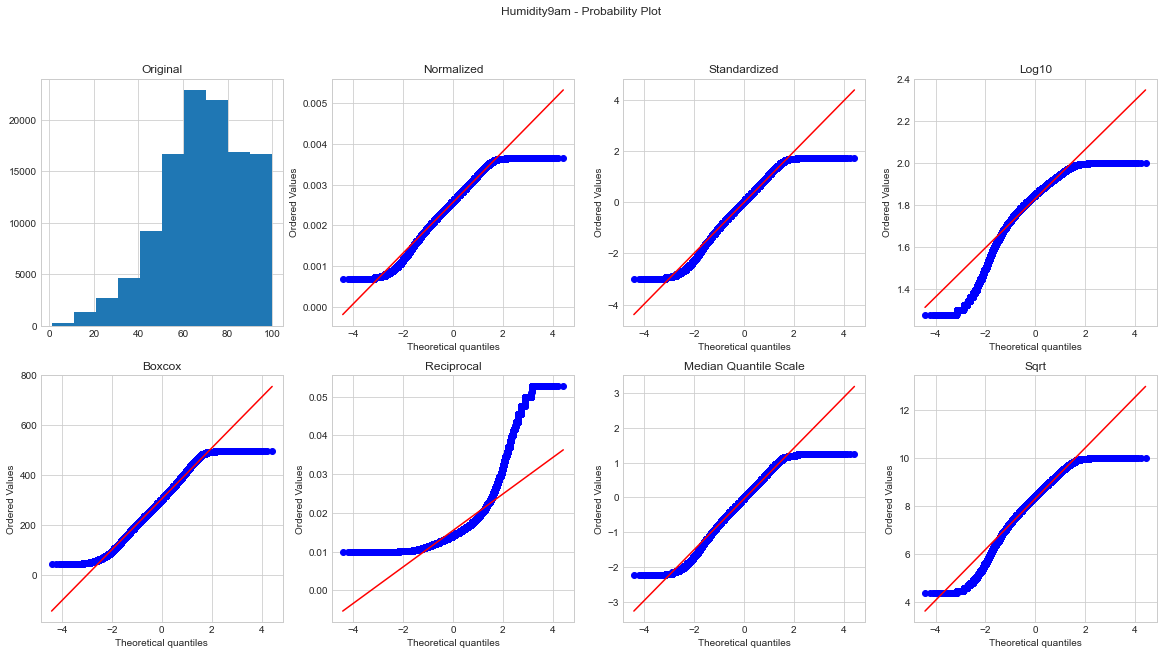

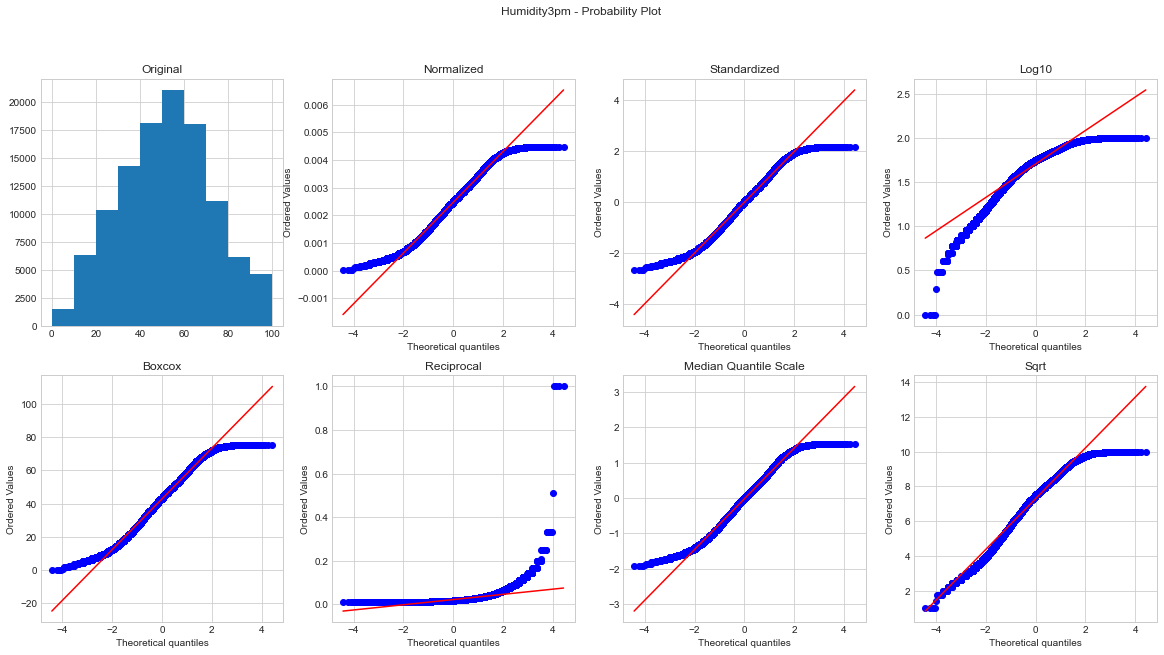

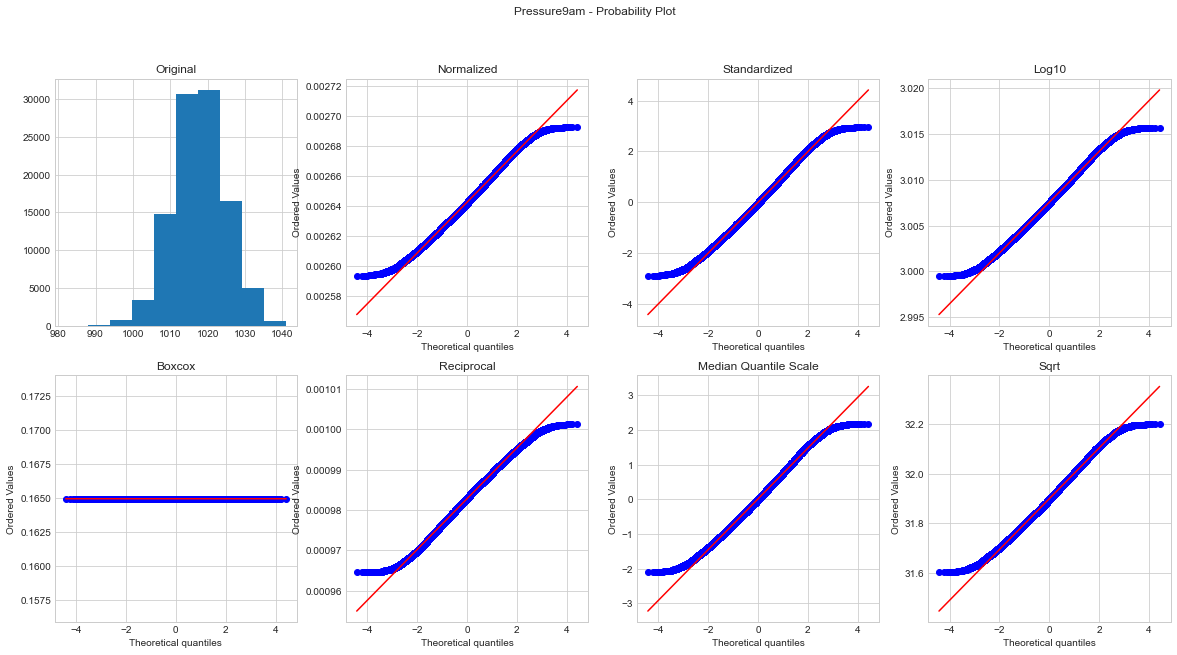

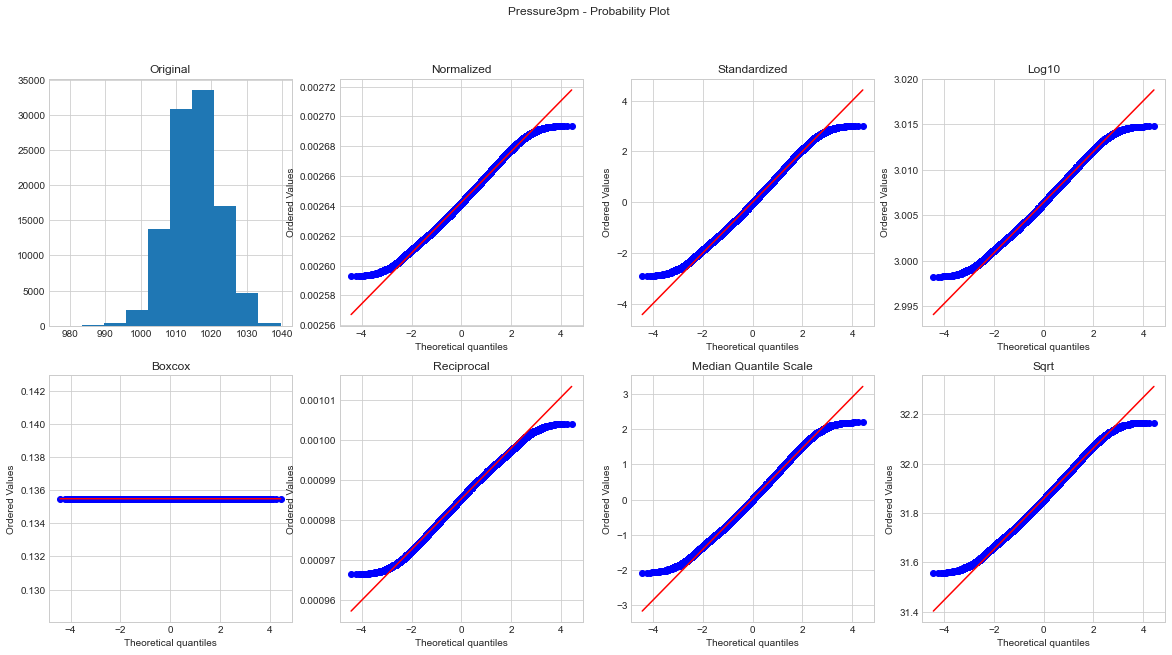

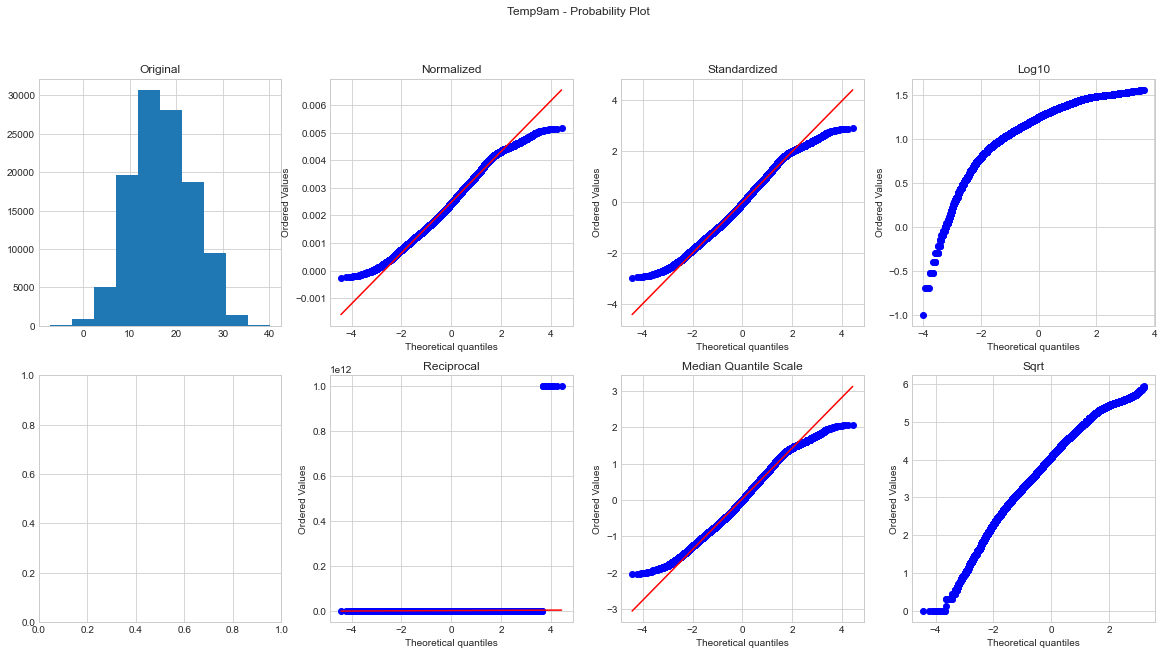

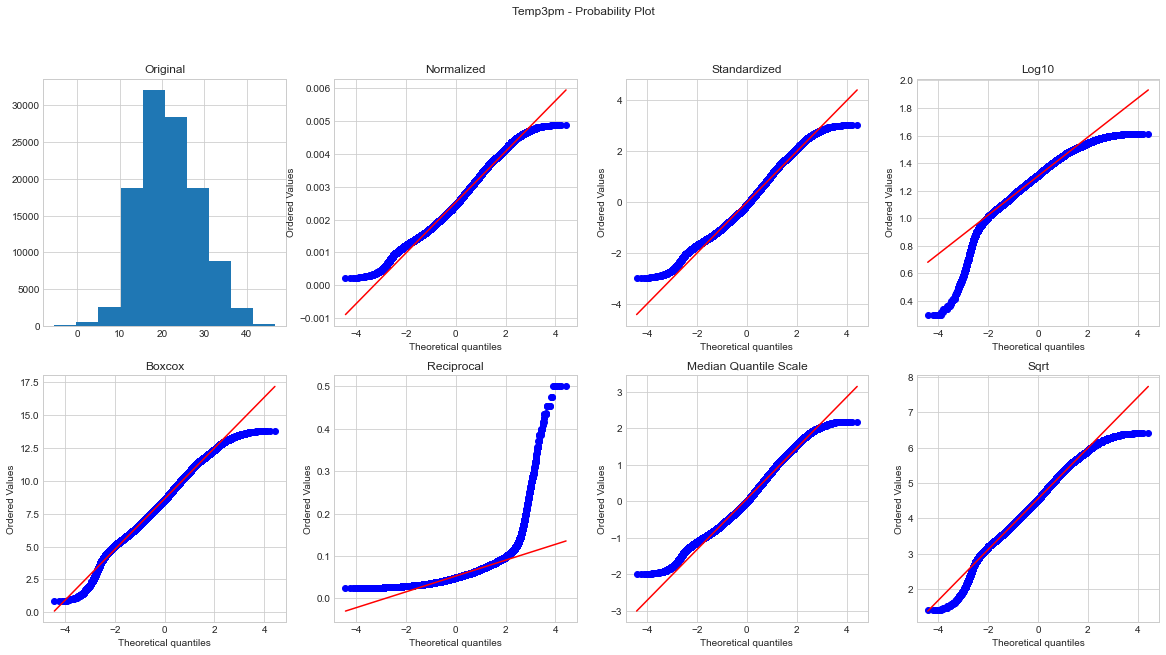

In [113]:
t = Transformations(df3)
for ncol in num_cols:
    
    plt.figure(figsize = (20, 10))
    
    plt.suptitle(f'{ncol} - Probability Plot')
    
    plt.subplot(2, 4, 1)
    plt.hist(df[ncol])
    plt.title('Original')
    
    plt.subplot(2, 4, 2)
    stats.probplot(t.normalize(ncol), dist = 'norm', plot = pylab)
    plt.title('Normalized')
    
    plt.subplot(2, 4, 3)
    stats.probplot(t.standardize(ncol), dist = 'norm', plot = pylab)
    plt.title('Standardized')
    
    try:
        plt.subplot(2, 4, 4)
        stats.probplot(t.log10(ncol), dist = 'norm', plot = pylab)
        plt.title('Log10')
    except:
        pass
    
    try:
        plt.subplot(2, 4, 5)
        stats.probplot(t.boxcox(ncol), dist = 'norm', plot = pylab)
        plt.title('Boxcox')
    except:
        pass
    
    try:
        plt.subplot(2, 4, 6)
        stats.probplot(t.reciprocal(ncol), dist = 'norm', plot = pylab)
        plt.title('Reciprocal')
    except:
        pass
    
    plt.subplot(2, 4, 7)
    stats.probplot(t.med_quant_scale(ncol), dist = 'norm', plot = pylab)
    plt.title('Median Quantile Scale')
    
    plt.subplot(2, 4, 8)
    stats.probplot(t.sqrt(ncol), dist = 'norm', plot = pylab)
    plt.title('Sqrt')
    
    plt.show()
    print('\n\n\n')

Standardization seems to work well for all the numerical features. So, we will transform all the numerical features using standard scaler. 

note: One could also try other transformation, will could work well too for some features.

### Feature Selection

##### Feature selection of categorical features (using chi-square)

In [185]:
# H0: There is no relation between the columns
# H1: There is a relation between columns

p_val = 0.05
check_chi2 = []
p_values = []
chi2_score = []
for ccol in cat_cols:
    chi2_out = chi2_contingency(pd.crosstab(df3['RainTomorrow'], df3[ccol]))
    chi2_score.append(chi2_out[0])
    p_values.append(chi2_out[1])
    if chi2_out[1] < p_val:
        check_chi2.append('Reject Null Hypothesis')
        
    else:
        check_chi2.append('Failed to Reject Null Hypothesis')
        
chi2_res = pd.DataFrame([cat_cols, check_chi2, p_values, chi2_score]).T
chi2_res.columns = ['Columns', 'Hypothesis', 'p_value', 'Chi2_Score']
chi2_res

,Columns,Hypothesis,p_value,Chi2_Score
0,Year,Reject Null Hypothesis,0.0,977.025057
1,Month,Reject Null Hypothesis,0.0,1154.797181
2,Date,Reject Null Hypothesis,0.0,449.347092
3,WeekYear,Reject Null Hypothesis,0.0,2597.501577
4,WeekDay,Reject Null Hypothesis,0.0,166.987287
5,WeekMonth,Reject Null Hypothesis,0.0,516.240988
6,Location,Reject Null Hypothesis,0.0,7706.04074
7,WindGustDir,Reject Null Hypothesis,0.0,4278.685969
8,WindDir9am,Reject Null Hypothesis,0.0,6429.410082
9,WindDir3pm,Reject Null Hypothesis,0.0,4127.175552


In [187]:
# Post Hoc
check_chi2_ph = {}
chi2_score = []
p_values = []
m = 0
for pcol in chi2_res.loc[chi2_res['Hypothesis'] == 'Reject Null Hypothesis', 'Columns']:
    ohe = pd.get_dummies(df3[pcol])
    bon_pval = p_val/df3[pcol].nunique()
    
    for oh in ohe.columns:
        chi2 = chi2_contingency(pd.crosstab(df3['RainTomorrow'], ohe[oh]))
        chi2_score.append(chi2[0])
        p_values.append(chi2[1])
        if chi2[1] < bon_pval:
            check_chi2_ph[f'{pcol}-{oh}'] = 'Reject Null Hypothesis'
        else:
            check_chi2_ph[f'{pcol}-{oh}'] = 'Failed to Reject Null Hypothesis'

In [188]:
res_chi2 = pd.DataFrame([check_chi2_ph.keys(), check_chi2_ph.values(), p_values, chi2_score]).T
res_chi2.columns = ['Pair', 'Hypothesis', 'p_values', 'chi2_score']
res_chi2

,Pair,Hypothesis,p_values,chi2_score
0,Year-2007,Failed to Reject Null Hypothesis,1.0,0.0
1,Year-2008,Reject Null Hypothesis,0.0,30.740718
2,Year-2009,Reject Null Hypothesis,0.0,40.612036
3,Year-2010,Reject Null Hypothesis,0.0,123.812818
4,Year-2011,Reject Null Hypothesis,0.0,130.841282
...,...,...,...,...
305,Temp3pm_grp-2,Reject Null Hypothesis,0.0,2672.630248
306,Temp3pm_grp-3,Reject Null Hypothesis,0.0,765.054881
307,Temp3pm_grp-4,Reject Null Hypothesis,0.0,1377.308792
308,Temp3pm_grp-5,Reject Null Hypothesis,0.0,1247.593834


In [189]:
res_chi2.head(10)

,Pair,Hypothesis,p_values,chi2_score
0,Year-2007,Failed to Reject Null Hypothesis,1.0,0.0
1,Year-2008,Reject Null Hypothesis,0.0,30.740718
2,Year-2009,Reject Null Hypothesis,0.0,40.612036
3,Year-2010,Reject Null Hypothesis,0.0,123.812818
4,Year-2011,Reject Null Hypothesis,0.0,130.841282
5,Year-2012,Reject Null Hypothesis,0.000001,24.404593
6,Year-2013,Reject Null Hypothesis,0.000139,14.514119
7,Year-2014,Reject Null Hypothesis,0.0,40.479387
8,Year-2015,Reject Null Hypothesis,0.0,33.500997
9,Year-2016,Reject Null Hypothesis,0.0,317.532128


In [190]:
res_chi2['Hypothesis'].value_counts()

Reject Null Hypothesis              253
Failed to Reject Null Hypothesis     57
Name: Hypothesis, dtype: int64

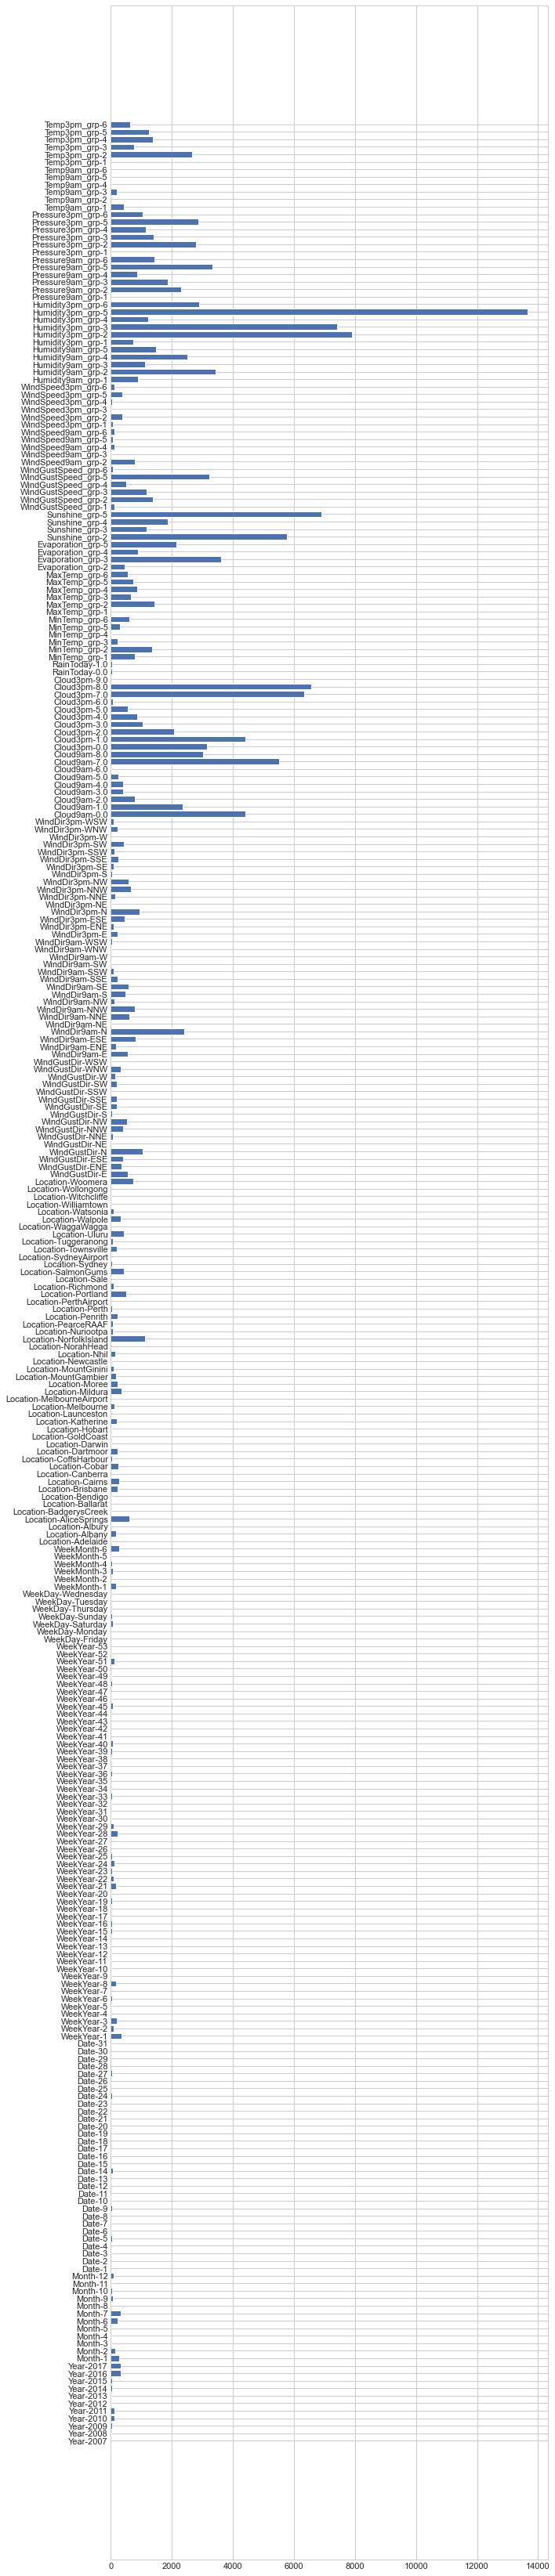

In [191]:
plt.figure(figsize= (10, 60))
plt.barh(res_chi2['Pair'], res_chi2['chi2_score'])
plt.show()

In [193]:
df4 = pd.get_dummies(df3, drop_first = False, columns = cat_cols)
Valdf_4 = pd.get_dummies(Valdf_3, drop_first = False, columns = cat_cols)

In [194]:
val_cols = Valdf_4.columns
for i in df4.columns:
    if i not in val_cols:
        print(i)
        Valdf_4[i] = 0

Cloud3pm_9.0


In [196]:
selected_cat_col = []
for i in res_chi2.loc[res_chi2['Hypothesis'] == 'Reject Null Hypothesis', 'Pair']:
    selected_cat_col.append('_'.join(i.split('-')))
    
selected_cols = []
for col in df4.columns:
    if col.split('_')[0] not in cat_cols:
        selected_cols.append(col)
    elif col in selected_cat_col:
        selected_cols.append(col)
        

if 'RainToday_0.0' in selected_cols:
        selected_cols.remove('RainToday_0.0') # drop_first = True, since both RainToday_(0.0 / 1.0) was available
selected_cols

['MinTemp',
 'MaxTemp',
 'Rainfall',
 'Evaporation',
 'Sunshine',
 'WindGustSpeed',
 'WindSpeed9am',
 'WindSpeed3pm',
 'Humidity9am',
 'Humidity3pm',
 'Pressure9am',
 'Pressure3pm',
 'Temp9am',
 'Temp3pm',
 'RainTomorrow',
 'Year_2008',
 'Year_2009',
 'Year_2010',
 'Year_2011',
 'Year_2012',
 'Year_2013',
 'Year_2014',
 'Year_2015',
 'Year_2016',
 'Year_2017',
 'Month_1',
 'Month_2',
 'Month_3',
 'Month_4',
 'Month_6',
 'Month_7',
 'Month_8',
 'Month_9',
 'Month_10',
 'Month_12',
 'Date_3',
 'Date_5',
 'Date_6',
 'Date_7',
 'Date_9',
 'Date_10',
 'Date_14',
 'Date_15',
 'Date_16',
 'Date_22',
 'Date_24',
 'Date_25',
 'Date_27',
 'Date_31',
 'WeekYear_1',
 'WeekYear_2',
 'WeekYear_3',
 'WeekYear_5',
 'WeekYear_6',
 'WeekYear_8',
 'WeekYear_9',
 'WeekYear_10',
 'WeekYear_11',
 'WeekYear_12',
 'WeekYear_15',
 'WeekYear_16',
 'WeekYear_17',
 'WeekYear_19',
 'WeekYear_20',
 'WeekYear_21',
 'WeekYear_22',
 'WeekYear_23',
 'WeekYear_24',
 'WeekYear_25',
 'WeekYear_28',
 'WeekYear_29',
 'WeekY

In [197]:
df5 = df4.loc[:, selected_cols].copy()
df5

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainTomorrow,Year_2008,...,Pressure3pm_grp_3,Pressure3pm_grp_4,Pressure3pm_grp_5,Pressure3pm_grp_6,Temp9am_grp_1,Temp9am_grp_2,Temp9am_grp_3,Temp9am_grp_4,Temp9am_grp_5,Temp9am_grp_6,Temp3pm_grp_1,Temp3pm_grp_2,Temp3pm_grp_3,Temp3pm_grp_4,Temp3pm_grp_5,Temp3pm_grp_6
0,12.900000,25.700000,0.000000,6.600000,8.000000,46.000000,19.000000,26.000000,38.000000,30.000000,1007.600000,1008.700000,21.000000,23.200000,0,1,...,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
1,9.200000,28.000000,0.000000,1.800000,9.500000,24.000000,11.000000,9.000000,45.000000,16.000000,1017.600000,1012.800000,18.100000,26.500000,0,1,...,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
2,17.500000,32.300000,1.000000,2.200000,8.500000,41.000000,7.000000,20.000000,82.000000,33.000000,1010.800000,1006.000000,17.800000,29.700000,0,1,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
3,14.300000,25.000000,0.000000,0.200000,12.400000,50.000000,20.000000,24.000000,49.000000,19.000000,1009.600000,1008.200000,18.100000,24.600000,0,1,...,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
4,7.700000,26.700000,0.000000,13.600000,11.200000,35.000000,6.000000,17.000000,48.000000,19.000000,1013.400000,1010.100000,16.300000,25.500000,0,1,...,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143071,2.115353,16.692324,0.200000,0.870788,8.592324,18.138590,1.292115,9.000000,99.784647,63.507468,1025.327718,1022.227718,3.992324,16.063112,1,0,...,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0
143072,10.730484,19.457373,0.184263,0.820322,1.913445,32.763940,17.236060,12.842627,66.921313,64.921313,1018.662949,1015.096716,16.506878,18.478687,1,0,...,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0
143073,14.138691,35.083976,0.000000,8.175476,6.848119,46.000000,9.877381,19.712262,22.575476,13.712262,1011.846702,1008.301417,26.464631,33.740107,1,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
143074,5.431725,14.831725,0.136551,2.215186,3.375868,47.268982,19.144790,26.731018,92.365509,76.634491,1003.231725,1000.244144,10.039317,14.151030,1,0,...,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0


##### Feature selection of numerical features (using ANOVA f-test)

In [199]:
skb = SelectKBest(f_classif, k = 11)

In [200]:
skb.fit(df5.loc[:, num_cols], df5.loc[:, 'RainTomorrow'])

SelectKBest(k=11)

In [201]:
skb.scores_

array([1.47342347e+03, 3.31743378e+03, 5.17474184e+03, 1.38380332e+03,
       1.17186657e+04, 5.53622523e+03, 4.29504812e+02, 4.51333490e+02,
       7.71887872e+03, 3.70293975e+04, 8.28365712e+03, 8.08018914e+03,
       1.10670057e-01, 5.55111830e+03])

In [202]:
np.int64(skb.get_support())

array([1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1], dtype=int64)

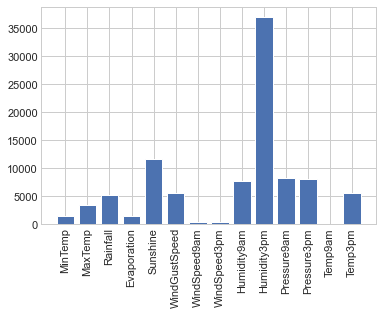

In [203]:
# plt.figure(figsize = (10, 10))
plt.bar(num_cols, skb.scores_)
plt.xticks(rotation = 90)
plt.show()

In [204]:
selected_num_cols = []
not_selected_num_cols = []
for i, j in zip(num_cols, skb.get_support()):
    if j:
        selected_num_cols.append(i)
    else:
        not_selected_num_cols.append(i)
        
selected_num_cols, not_selected_num_cols

(['MinTemp',
  'MaxTemp',
  'Rainfall',
  'Evaporation',
  'Sunshine',
  'WindGustSpeed',
  'Humidity9am',
  'Humidity3pm',
  'Pressure9am',
  'Pressure3pm',
  'Temp3pm'],
 ['WindSpeed9am', 'WindSpeed3pm', 'Temp9am'])

In [205]:
tot_selected_cols = list(set(selected_cols) - set(not_selected_num_cols))
len(tot_selected_cols), tot_selected_cols

(270,
 ['Location_Townsville',
  'Location_BadgerysCreek',
  'Temp3pm_grp_2',
  'Cloud3pm_6.0',
  'WeekYear_17',
  'Humidity9am_grp_4',
  'Temp9am_grp_6',
  'WindDir9am_SW',
  'WindSpeed9am_grp_6',
  'Month_8',
  'Sunshine_grp_4',
  'Sunshine',
  'WeekYear_10',
  'WindDir3pm_ENE',
  'WindDir3pm_NNE',
  'Month_2',
  'WindDir9am_NNW',
  'Location_GoldCoast',
  'Pressure3pm',
  'Month_3',
  'Temp9am_grp_3',
  'Date_9',
  'WindGustDir_SSE',
  'Year_2010',
  'Cloud3pm_0.0',
  'MinTemp_grp_5',
  'Pressure9am_grp_6',
  'WeekYear_25',
  'WindGustSpeed_grp_4',
  'Location_Katherine',
  'Cloud3pm_7.0',
  'Pressure3pm_grp_5',
  'WindDir3pm_N',
  'WindDir9am_NW',
  'WindGustSpeed_grp_3',
  'Humidity9am_grp_5',
  'Humidity3pm_grp_3',
  'WeekDay_Tuesday',
  'Location_Albury',
  'Location_Watsonia',
  'MaxTemp_grp_6',
  'Location_Hobart',
  'WindDir9am_N',
  'RainToday_1.0',
  'WindSpeed3pm_grp_5',
  'Pressure3pm_grp_4',
  'Temp3pm',
  'WeekYear_45',
  'Cloud3pm_3.0',
  'WindDir9am_WNW',
  'Cloud9am_

In [206]:
df6 = df5.loc[:, tot_selected_cols]

Another way of selecting feature is through, running randomforest classifier for multiple times and then taking the important features. But here, we are going to run this for single time to get important features.

In [207]:
X = df6.drop('RainTomorrow', axis = 1)
y = df6.loc[: , 'RainTomorrow']

In [208]:
pipe = Pipeline([
        ('standard_scaler', StandardScaler()),
        ('model', RandomForestClassifier())
    ])

In [209]:
pipe.fit(X, y)

Pipeline(steps=[('standard_scaler', StandardScaler()),
                ('model', RandomForestClassifier())])

In [210]:
ft_imp = pipe.steps[1][1].feature_importances_

In [211]:
ft_imp_df = pd.DataFrame([X.columns, ft_imp]).T
ft_imp_df.columns = ['Columns', 'Importance']
ft_imp_df.sort_values('Importance', ascending = True, inplace = True)
ft_imp_df

,Columns,Importance
220,Rainfall_grp_3,0.0
264,WindGustSpeed_grp_1,0.000132
159,WeekYear_53,0.000178
256,Location_Uluru,0.000224
92,MaxTemp_grp_1,0.000268
...,...,...
206,WindGustSpeed,0.035842
18,Pressure3pm,0.038196
11,Sunshine,0.044847
114,Rainfall,0.047825


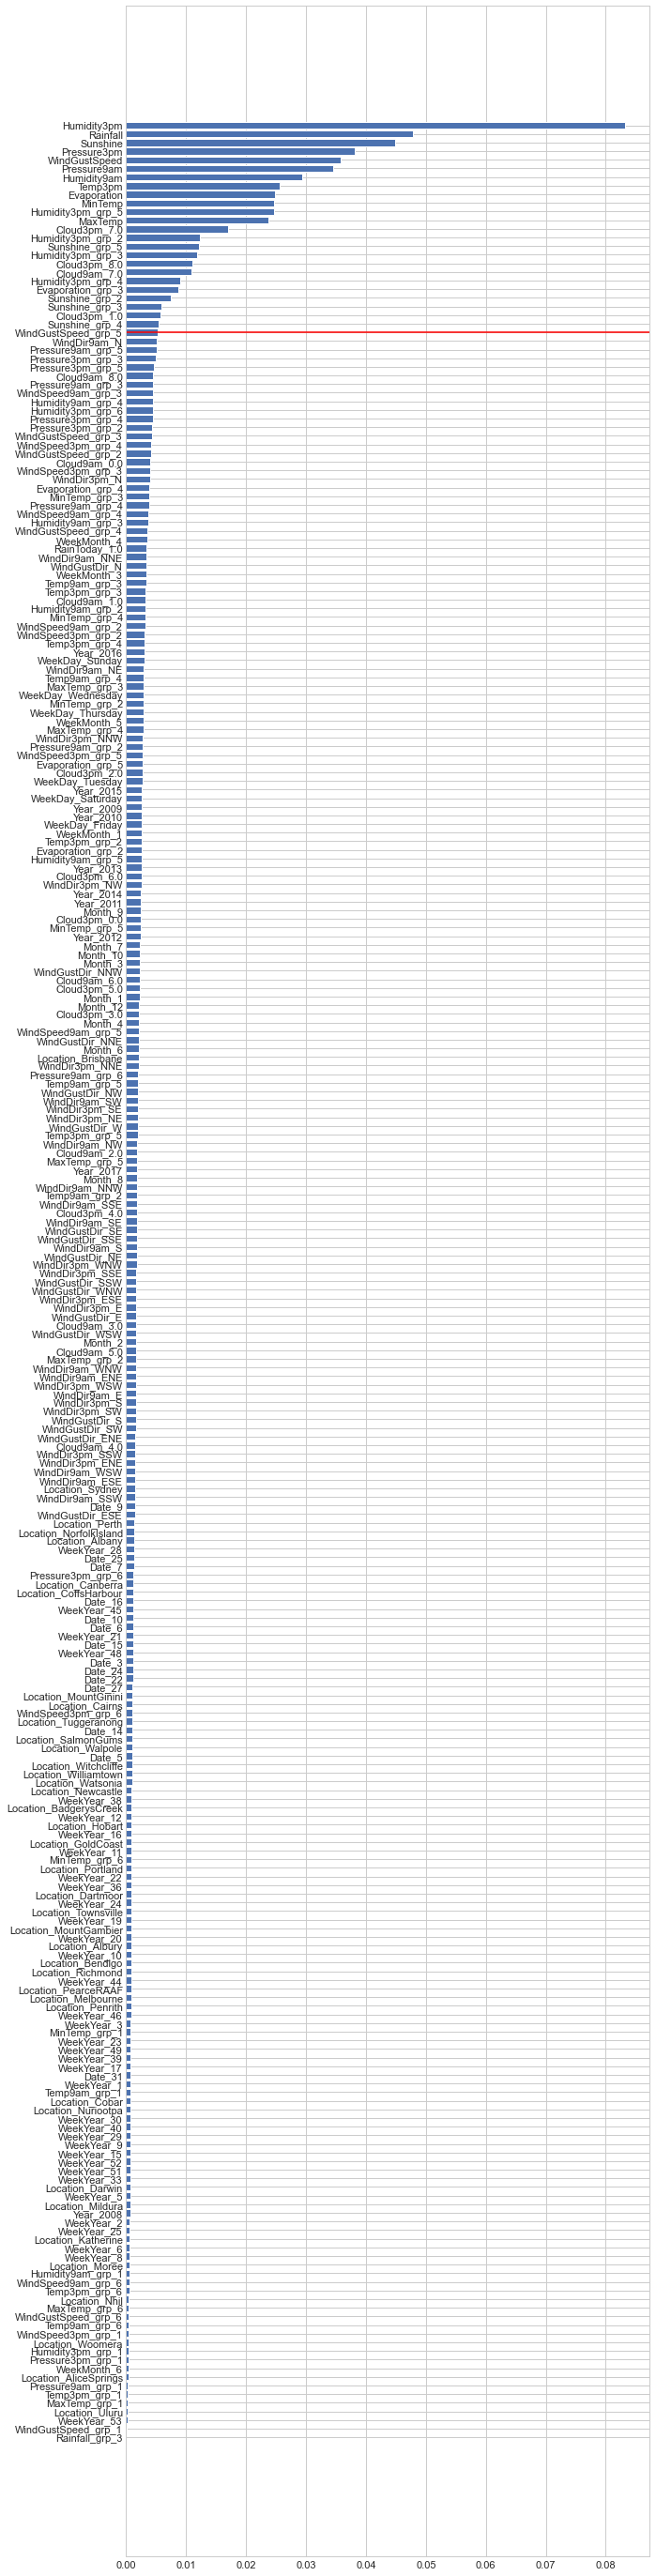

In [212]:
ft_selected = 25

plt.figure(figsize = (10, 50))
plt.barh(ft_imp_df['Columns'], ft_imp_df['Importance'])
plt.axhline(len(ft_imp_df) - ft_selected, color='red')
plt.show()

In [213]:
FX = df6.loc[:, ft_imp_df['Columns'][:-(ft_selected+1):-1].values]
FX

,Humidity3pm,Rainfall,Sunshine,Pressure3pm,WindGustSpeed,Pressure9am,Humidity9am,Temp3pm,Evaporation,MinTemp,Humidity3pm_grp_5,MaxTemp,Cloud3pm_7.0,Humidity3pm_grp_2,Sunshine_grp_5,Humidity3pm_grp_3,Cloud3pm_8.0,Cloud9am_7.0,Humidity3pm_grp_4,Evaporation_grp_3,Sunshine_grp_2,Sunshine_grp_3,Cloud3pm_1.0,Sunshine_grp_4,WindGustSpeed_grp_5
0,30.000000,0.000000,8.000000,1008.700000,46.000000,1007.600000,38.000000,23.200000,6.600000,12.900000,0,25.700000,0,1,0,0,0,1,0,0,0,0,0,1,0
1,16.000000,0.000000,9.500000,1012.800000,24.000000,1017.600000,45.000000,26.500000,1.800000,9.200000,0,28.000000,0,1,0,0,0,0,0,1,0,0,0,1,0
2,33.000000,1.000000,8.500000,1006.000000,41.000000,1010.800000,82.000000,29.700000,2.200000,17.500000,0,32.300000,0,0,0,1,1,1,0,1,0,0,0,1,0
3,19.000000,0.000000,12.400000,1008.200000,50.000000,1009.600000,49.000000,24.600000,0.200000,14.300000,0,25.000000,1,1,1,0,0,0,0,0,0,0,0,0,0
4,19.000000,0.000000,11.200000,1010.100000,35.000000,1013.400000,48.000000,25.500000,13.600000,7.700000,0,26.700000,1,1,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143071,63.507468,0.200000,8.592324,1022.227718,18.138590,1025.327718,99.784647,16.063112,0.870788,2.115353,0,16.692324,1,0,0,0,0,0,1,0,0,0,0,1,0
143072,64.921313,0.184263,1.913445,1015.096716,32.763940,1018.662949,66.921313,18.478687,0.820322,10.730484,0,19.457373,1,0,0,0,0,1,1,1,1,0,0,0,0
143073,13.712262,0.000000,6.848119,1008.301417,46.000000,1011.846702,22.575476,33.740107,8.175476,14.138691,0,35.083976,1,1,0,0,0,0,0,0,0,0,0,1,0
143074,76.634491,0.136551,3.375868,1000.244144,47.268982,1003.231725,92.365509,14.151030,2.215186,5.431725,1,14.831725,1,0,0,0,0,1,0,1,1,0,0,0,0


### Creating Model

In [214]:
pipe = Pipeline([
        ('standard_scaler', StandardScaler()),
        ('model', RandomForestClassifier())
    ])

In [215]:
pipe.fit(FX, y)

Pipeline(steps=[('standard_scaler', StandardScaler()),
                ('model', RandomForestClassifier())])

In [216]:
pipe.score(FX, y)

0.9999930107075959

In [217]:
pipe.score(Valdf_4.loc[:, FX.columns], Valdf_4.loc[:, 'RainTomorrow'])

0.8124074622445958

### Hyperparameter Tuning

In [323]:
model = Pipeline([
    ('StandardScaler', StandardScaler()),
    ('random_forest', RandomForestClassifier())
])

In [337]:
params = {
    'random_forest__n_estimators': np.arange(100, 501, 100),
    'random_forest__n_estimators': np.arange(2, 15, 2),
    'random_forest__criterion': ['gini', 'entropy'],
    'random_forest__min_samples_split': np.arange(2, 6)
    }

grid_cv = GridSearchCV(model, params, cv = 5)

In [339]:
grid_cv.fit(FX, y)

# * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 